# Initialization of data and libraries

In this part we initialise our libraries and dataset as well as create splitting and cleaning functions.

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shapely.geometry
import geopandas as gpd
import numpy as np
import mpl_toolkits
import cartopy.crs as ccrs
import statsmodels.api as sm
import cartopy.feature as cfeature
from scipy import stats


data = pd.read_csv("pollution_data.csv")
data_copy = data.copy()
data_copy["Population Staying at Home"] = data_copy["Population Staying at Home"].str.replace(",", "").astype(int)
data_copy["Population Not Staying at Home"] = data_copy["Population Not Staying at Home"].str.replace(",", "").astype(int)

# Create the total_population column
data_copy["total_population"] = data_copy["Population Staying at Home"] + data_copy["Population Not Staying at Home"]

# Make date datetime type
data_copy['Date'] = pd.to_datetime(data_copy['Date'])

# Split dataset on data before and after covid outbreak
pre_covid = data_copy[data_copy['Date'] < pd.to_datetime('2020-01-13')].copy()
post_covid = data_copy[data_copy['Date'] >= pd.to_datetime('2020-01-13')].copy()

def remove_exess_dates(pre_covid, post_covid):
    # make copies to not work on original data
    pre_covid_temp = pre_covid.copy()
    post_covid_temp = post_covid.copy()

    # create temp columns to help with grouping
    pre_covid_temp['DayMonth'] = pre_covid_temp['Date'].dt.strftime('%d-%m')
    post_covid_temp['DayMonth'] = post_covid_temp['Date'].dt.strftime('%d-%m')
    
    # list of post covid dates to be used in pre covid dataset
    pre_dates = set(pre_covid_temp[['DayMonth', 'City']].apply(tuple, axis = 1))
    post_dates = set(post_covid_temp[['DayMonth', 'City']].apply(tuple, axis = 1))

    unique_pre = pre_dates - post_dates
    unique_post = post_dates - pre_dates
    non_symmetric_dates = unique_pre | unique_post

    # remove excess dates
    pre_covid_temp = pre_covid_temp[~pre_covid_temp[['DayMonth', 'City']].apply(tuple, axis = 1).isin(non_symmetric_dates)]
    post_covid_temp = post_covid_temp[~post_covid_temp[['DayMonth', 'City']].apply(tuple, axis = 1).isin(non_symmetric_dates)]

    return pre_covid_temp, post_covid_temp

pre_covid, post_covid = remove_exess_dates(pre_covid, post_covid)

def detect_outliers_iqr(sf : pd.Series) -> pd.Series:
    Q1 = sf.quantile(0.25)
    Q3 = sf.quantile(0.75)
    IQR = Q3 - Q1
    outliers = sf[(sf < Q1 - 1.5 * IQR) | (sf > Q3 + 1.5 * IQR)]
    return outliers

def clean_pre_post_covid(pre_covid : pd.DataFrame, post_covid: pd.DataFrame, pollutant):
    """
    Takes pre and post covid data and returns symmetric and clean data without outliers nor missing values
    NOTE:
        DATA IS ONLY CLEAN FOR GIVEN POLLUTANT
        outputted datafreames are symetric i.e. dates are shared among both datasets
    """

    # make copies to not work on original data
    pre_covid_temp = pre_covid.copy()
    post_covid_temp = post_covid.copy()

    # create temp columns to help with grouping
    pre_covid_temp['DayMonth'] = pre_covid_temp['Date'].dt.strftime('%d-%m')
    post_covid_temp['DayMonth'] = post_covid_temp['Date'].dt.strftime('%d-%m')

    # get pollutants
    outliers_pollutant_pre = detect_outliers_iqr(pre_covid_temp[pollutant])
    outliers_pollutant_post = detect_outliers_iqr(post_covid_temp[pollutant])

    # get outlying rows
    outliers_rows = pre_covid_temp[pre_covid_temp[pollutant].isin(outliers_pollutant_pre)]
    outliers_rows = pd.concat([outliers_rows, post_covid_temp[post_covid_temp[pollutant].isin(outliers_pollutant_post)]])
    to_remove = set(outliers_rows[['DayMonth', 'City']].apply(tuple, axis = 1))
    
    # get missing values
    missing_valeus_pre = pre_covid_temp[pre_covid_temp[pollutant].isna()]
    missing_valeus_post = post_covid_temp[post_covid_temp[pollutant].isna()]
    missing_values = pd.concat([missing_valeus_pre, missing_valeus_post])

    # update to_remove
    to_remove = to_remove | set(missing_values[['DayMonth', 'City']].apply(tuple, axis = 1))

    # remove unwanted rows
    pre_covid_cleaned = pre_covid_temp[~pre_covid_temp[['DayMonth', 'City']].apply(tuple, axis = 1).isin(to_remove)]
    post_covid_cleaned = post_covid_temp[~post_covid_temp[['DayMonth', 'City']].apply(tuple, axis = 1).isin(to_remove)]

    return pre_covid_cleaned, post_covid_cleaned

def clean_features(data: pd.DataFrame, features: list, pollutant: str) -> pd.DataFrame:

    """
    function cleans data and prepares it to be used in regression models

    data = full dataset
    features = list of features
    pollutant = target pollution
    """

    # extract relevant data
    relevant_columns = features + [pollutant]
    data_copy = data[relevant_columns].copy()

    # drop missing values
    data_copy.dropna(subset = pollutant, inplace = True)
    
    # find outlying vaslues in target column
    outliers_indexes =  set(data_copy[data_copy[pollutant].isin(detect_outliers_iqr(data_copy[pollutant]))].index)

    # drop outliers
    clean_data = data_copy.drop(outliers_indexes)

    return clean_data

pre_covid.head(10)

Date         City       County State  Population Staying at Home  \
592 2019-01-13  albuquerque   bernalillo    NM                      137663   
593 2019-01-13      atlanta       fulton    GA                      240279   
594 2019-01-13       austin       travis    TX                      221051   
595 2019-01-13    baltimore      baltimo    MD                      175913   
596 2019-01-13        boise          ada    ID                       90835   
597 2019-01-13       boston      suffolk    MA                      229055   
598 2019-01-13     brooklyn        kings    NY                      827925   
599 2019-01-13    charlotte  mecklenburg    NC                      231679   
600 2019-01-13      chicago         cook    IL                     1214619   
601 2019-01-13     columbia     richland    SC                       75489   

     Population Not Staying at Home   mil_miles  past_week_avg_miles  \
592                          538964   23.037336                  0.0   
593                          806625   30.278924                  0.0   
594                         1023875   32.217678                  0.0   
595                          424740   13.807414                  0.0   
596                          377695   13.948428                  0.0   
597                          575730   19.335677                  0.0   
598                         1747010   56.570393                  0.0   
599                          858878   32.941750                  0.0   
600                         3950040  163.154364                  0.0   
601                          337820   13.335603                  0.0   

      latitude   longitude  ...  pm10_variance  pm10_count  wind-gust_min  \
592  35.107209 -106.617209  ...         167.53        47.0            1.0   
593  33.760109  -84.402826  ...         188.62        24.0            0.2   
594  30.283333  -97.750641  ...            NaN         NaN            0.2   
595  39.305833  -76.610417  ...          77.10        24.0            0.1   
596  43.604545 -116.202424  ...         171.35        44.0            0.2   
597  42.351282  -71.062051  ...            NaN         NaN            1.1   
598  40.653269  -73.956538  ...            NaN         NaN            3.0   
599  35.196351  -80.828108  ...            NaN         NaN            0.1   
600  41.858851  -87.676437  ...         206.30        47.0            0.5   
601  34.011818  -81.013333  ...            NaN         NaN            0.2   

     wind-gust_max  wind-gust_median  wind-gust_variance  wind-gust_count  \
592           12.0               3.3              132.47             48.0   
593            5.5               4.0               25.73             48.0   
594           11.8               6.0              137.16             60.0   
595           12.0               2.7              111.95             69.0   
596            7.0               2.0               29.34             84.0   
597           15.2               7.0              110.92            120.0   
598           25.4               9.8              220.69            120.0   
599           12.0               3.2              102.06             90.0   
600           19.5               9.0              181.15            192.0   
601            7.2               2.4               28.74             48.0   

       pp_feat  total_population  DayMonth  
592   0.319492            676627     13-01  
593  23.304216           1046904     13-01  
594  14.333042           1244926     13-01  
595   6.403240            600653     13-01  
596   0.000000            468530     13-01  
597  86.681580            804785     13-01  
598  26.824525           2574935     13-01  
599   0.000000           1090557     13-01  
600   3.606315           5164659     13-01  
601   1.231301            413309     13-01  

[10 rows x 73 columns]

## Descriptive Statistics

In [4]:
statistics = data_copy.describe()
print(statistics)

                                Date  Population Staying at Home  \
count                          35596                3.559600e+04   
mean   2019-12-19 16:20:09.574109440                3.372613e+05   
min              2019-01-01 00:00:00                1.257200e+04   
25%              2019-06-21 00:00:00                1.398185e+05   
50%              2019-12-08 00:00:00                2.196440e+05   
75%              2020-06-19 00:00:00                3.912720e+05   
max              2020-12-11 00:00:00                3.644862e+06   
std                              NaN                3.820851e+05   

       Population Not Staying at Home     mil_miles  past_week_avg_miles  \
count                    3.559600e+04  35596.000000              35596.0   
mean                     1.124679e+06     46.856694                  0.0   
min                      4.878600e+04      1.461991                  0.0   
25%                      4.510015e+05     17.931973                  0.0   
50%    

## Correlation Matrix
Here we create a correlation Matrix with most interesting correlations

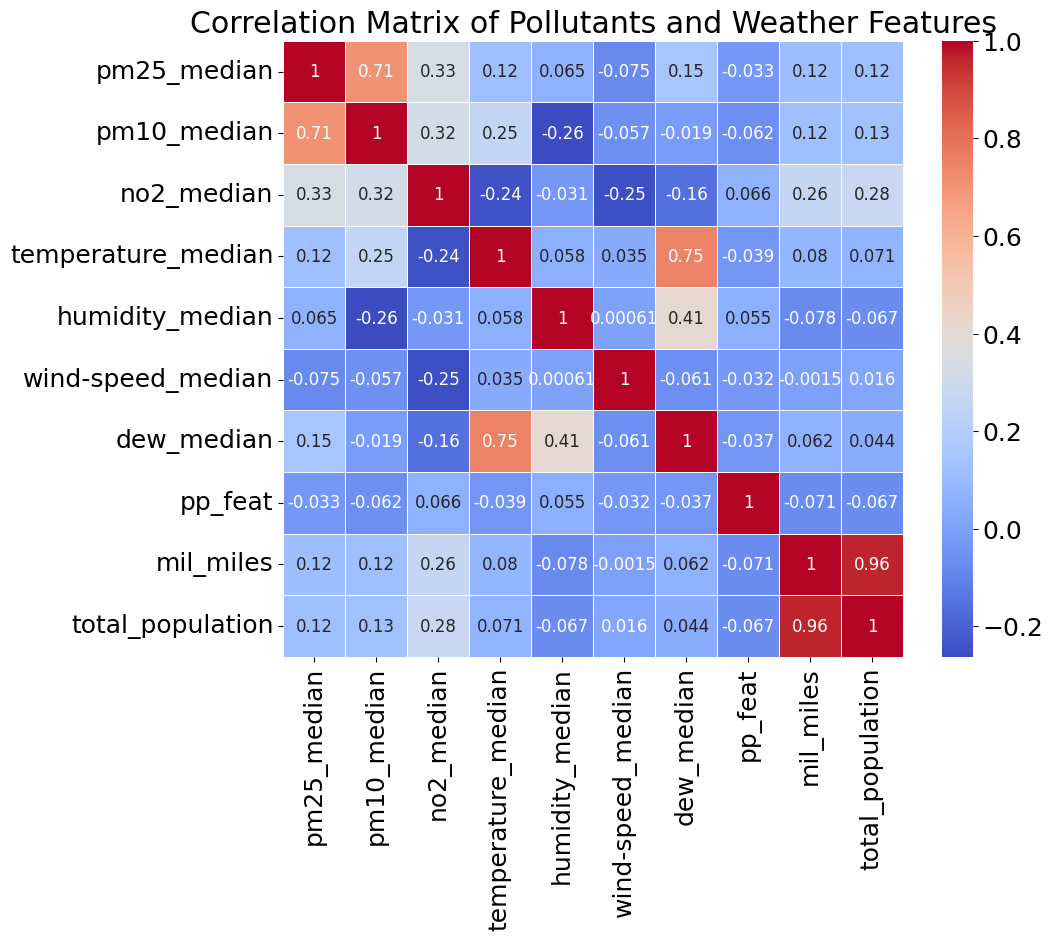

In [ ]:
correlation_columns = [
    'pm25_median', 'pm10_median', 'no2_median',
 'temperature_median', 'humidity_median', 'wind-speed_median','dew_median','pp_feat', 'mil_miles', 'total_population'
]


correlation_matrix = data_copy[correlation_columns].corr()

# Plotting the matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, annot_kws={"size": 12})
plt.title('Correlation Matrix of Pollutants and Weather Features')
plt.show()

## Cities per pollutant

We check how many cities have data for each of the pollutants

In [ ]:
pollutants = ['pm25_median', 'pm10_median', 'o3_median', 'no2_median','co_median','so2_median']
for column in pollutants:
     cities_with_data = len(data[data[column].notna()]['City'].unique())
     print(f"{column}: {cities_with_data} cities with data")

pm25_median: 54 cities with data
pm10_median: 31 cities with data
o3_median: 54 cities with data
no2_median: 43 cities with data
co_median: 42 cities with data
so2_median: 43 cities with data


## Checking for missing values in %

In [ ]:
for column in data.columns:
    missing_percentage = data[column].isna().mean() * 100
    print(f"{column}: {missing_percentage:.2f}% missing")

Date: 0.00% missing
City: 0.00% missing
County: 0.00% missing
State: 0.00% missing
Population Staying at Home: 0.00% missing
Population Not Staying at Home: 0.00% missing
mil_miles: 0.00% missing
past_week_avg_miles: 0.00% missing
latitude: 0.00% missing
longitude: 0.00% missing
o3_min: 4.62% missing
o3_max: 4.62% missing
o3_median: 4.62% missing
o3_variance: 4.62% missing
o3_count: 4.62% missing
pressure_min: 2.61% missing
pressure_max: 2.61% missing
pressure_median: 2.61% missing
pressure_variance: 2.61% missing
pressure_count: 2.61% missing
pm25_min: 1.30% missing
pm25_max: 1.30% missing
pm25_median: 1.30% missing
pm25_variance: 1.30% missing
pm25_count: 1.30% missing
humidity_min: 2.61% missing
humidity_max: 2.61% missing
humidity_median: 2.61% missing
humidity_variance: 2.61% missing
humidity_count: 2.61% missing
temperature_min: 2.64% missing
temperature_max: 2.64% missing
temperature_median: 2.64% missing
temperature_variance: 2.64% missing
temperature_count: 2.64% missing
dew_m

## Cheking for missing values

In [ ]:
for column in data.columns:
    missing_percentage = data[column].isna().sum()
    core = len(data["Date"]) - missing_percentage
    print(f"{column}: {core} missing")

Date: 35596 missing
City: 35596 missing
County: 35596 missing
State: 35596 missing
Population Staying at Home: 35596 missing
Population Not Staying at Home: 35596 missing
mil_miles: 35596 missing
past_week_avg_miles: 35596 missing
latitude: 35596 missing
longitude: 35596 missing
o3_min: 33950 missing
o3_max: 33950 missing
o3_median: 33950 missing
o3_variance: 33950 missing
o3_count: 33950 missing
pressure_min: 34667 missing
pressure_max: 34667 missing
pressure_median: 34667 missing
pressure_variance: 34667 missing
pressure_count: 34667 missing
pm25_min: 35134 missing
pm25_max: 35134 missing
pm25_median: 35134 missing
pm25_variance: 35134 missing
pm25_count: 35134 missing
humidity_min: 34668 missing
humidity_max: 34668 missing
humidity_median: 34668 missing
humidity_variance: 34668 missing
humidity_count: 34668 missing
temperature_min: 34658 missing
temperature_max: 34658 missing
temperature_median: 34658 missing
temperature_variance: 34658 missing
temperature_count: 34658 missing
dew_m

## Data cleaning visualization

This visualization shows how many data was removed after cleaning

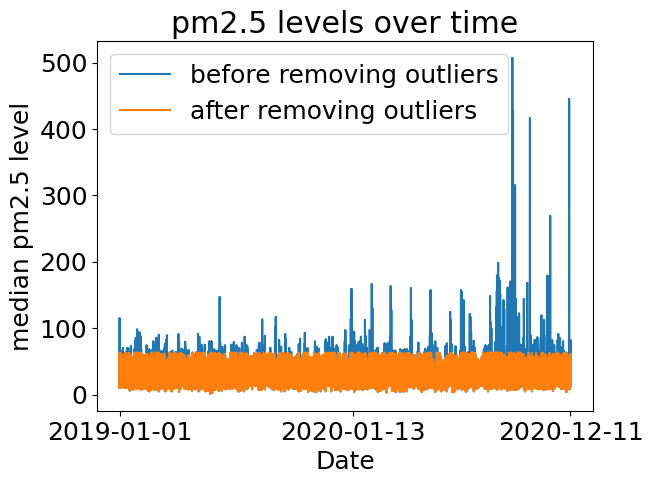

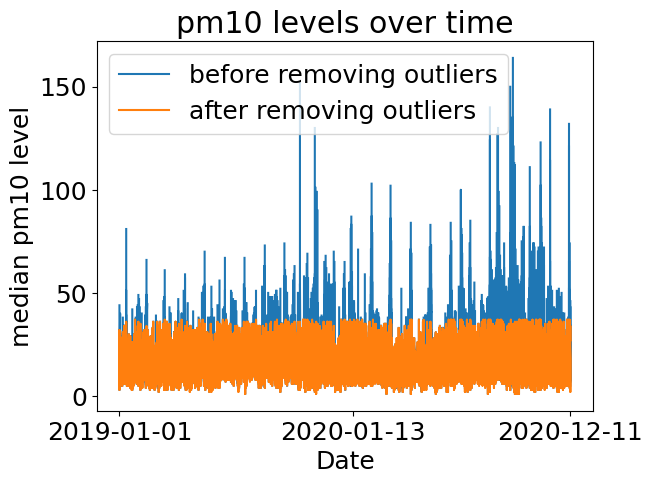

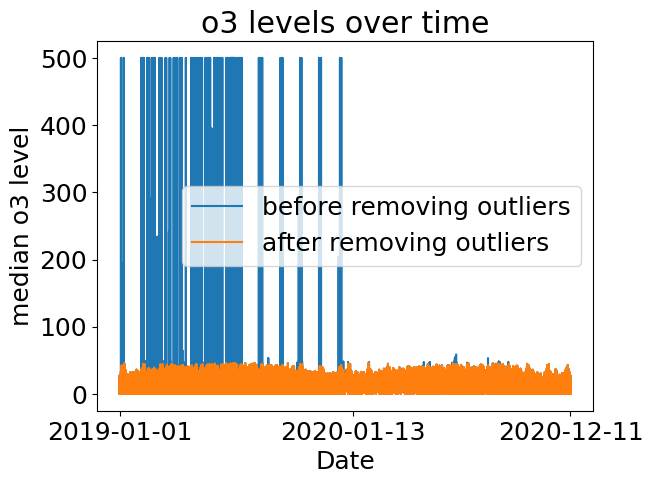

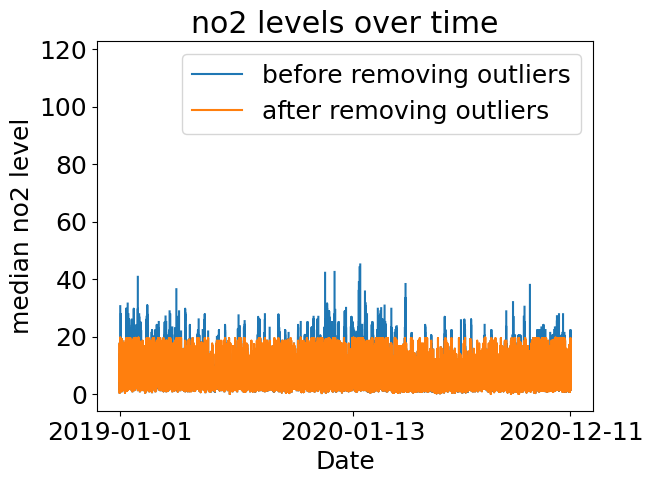

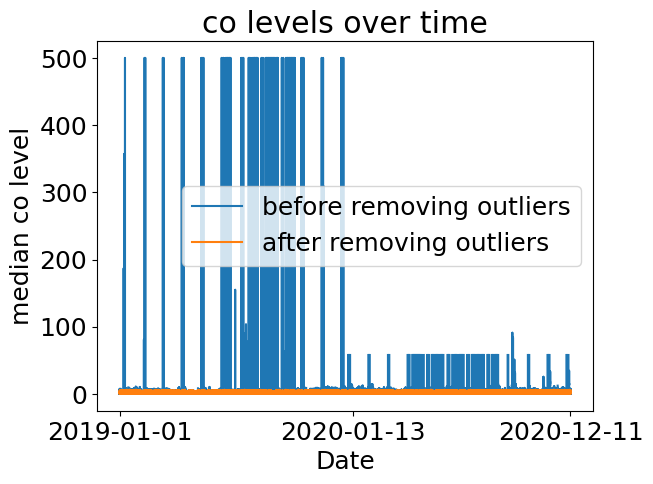

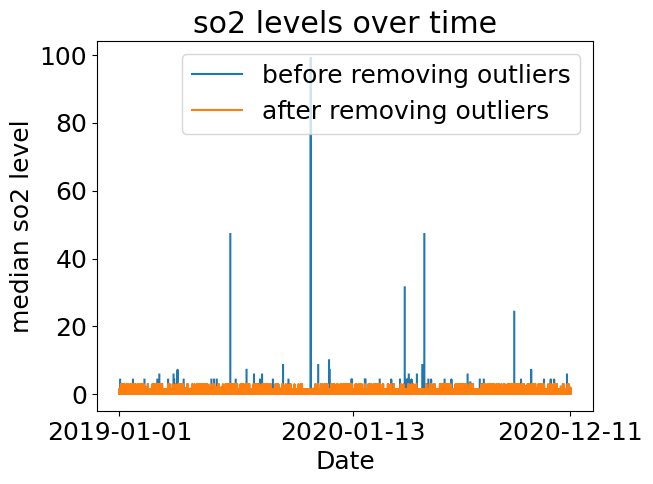

In [ ]:
pollutants = ['pm25_median', 'pm10_median', 'o3_median', 'no2_median', 'co_median', 'so2_median']

for pollutant in pollutants:
    data_pollutant = clean_features(data, ['Date'], pollutant)
    if pollutant == 'pm25_median':
        name = 'pm2.5'
    else:
        name = pollutant.split("_")[0]

    # determine reference points for dates to increase readability
    ref_points = [data['Date'].iloc[0], '2020-01-13', data['Date'].iloc[-1]]

    # plot before cleaning
    before, = plt.plot(data['Date'], data[pollutant], label=pollutant)

    # plot after cleaning
    after, = plt.plot(data_pollutant['Date'], data_pollutant[pollutant], label=pollutant)

    # name labels
    plt.xlabel('Date')
    plt.xticks(ticks = ref_points)
    plt.ylabel(f'median {name} level')
    plt.title(f'{name} levels over time')

    plt.legend([before, after], ['before removing outliers', 'after removing outliers'])

    plt.show()

## Data distributions visualisation

 Visual representation of how our pollutant data is distributed over time

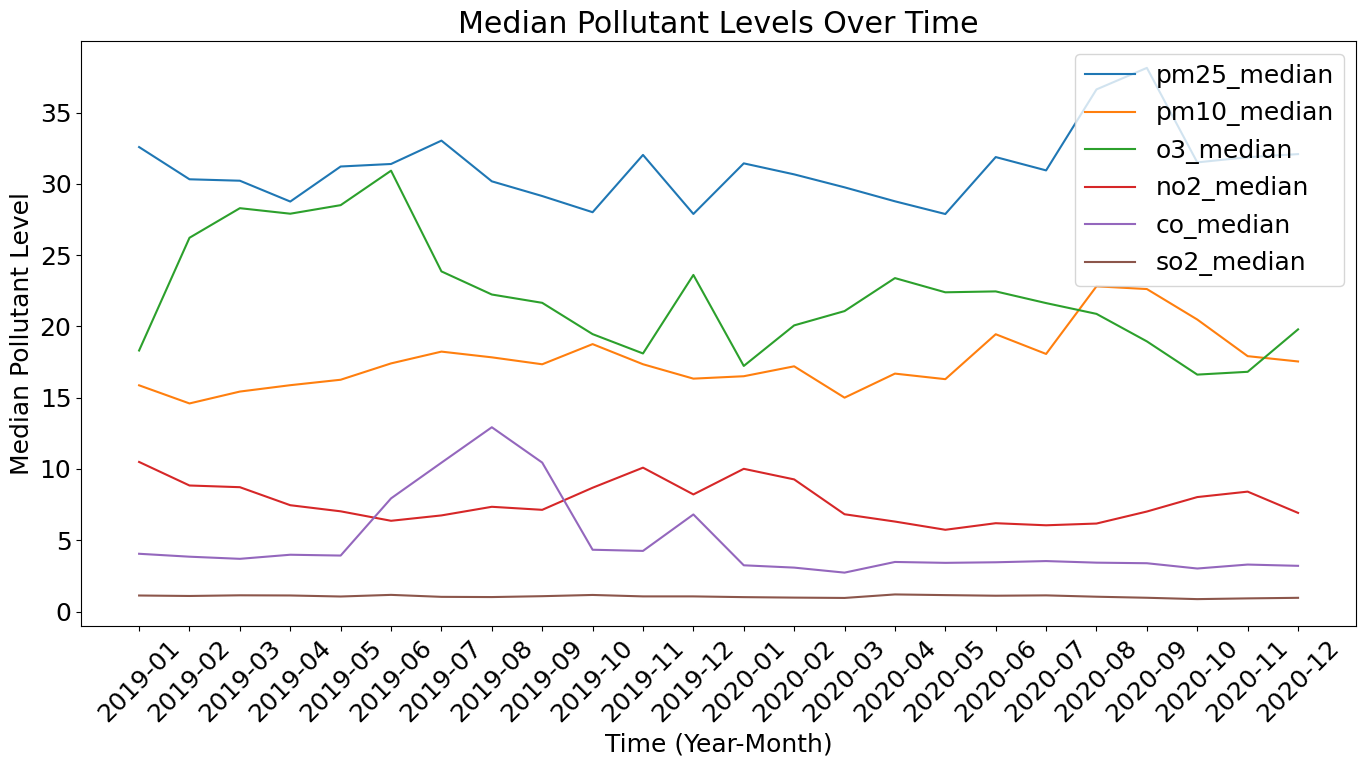

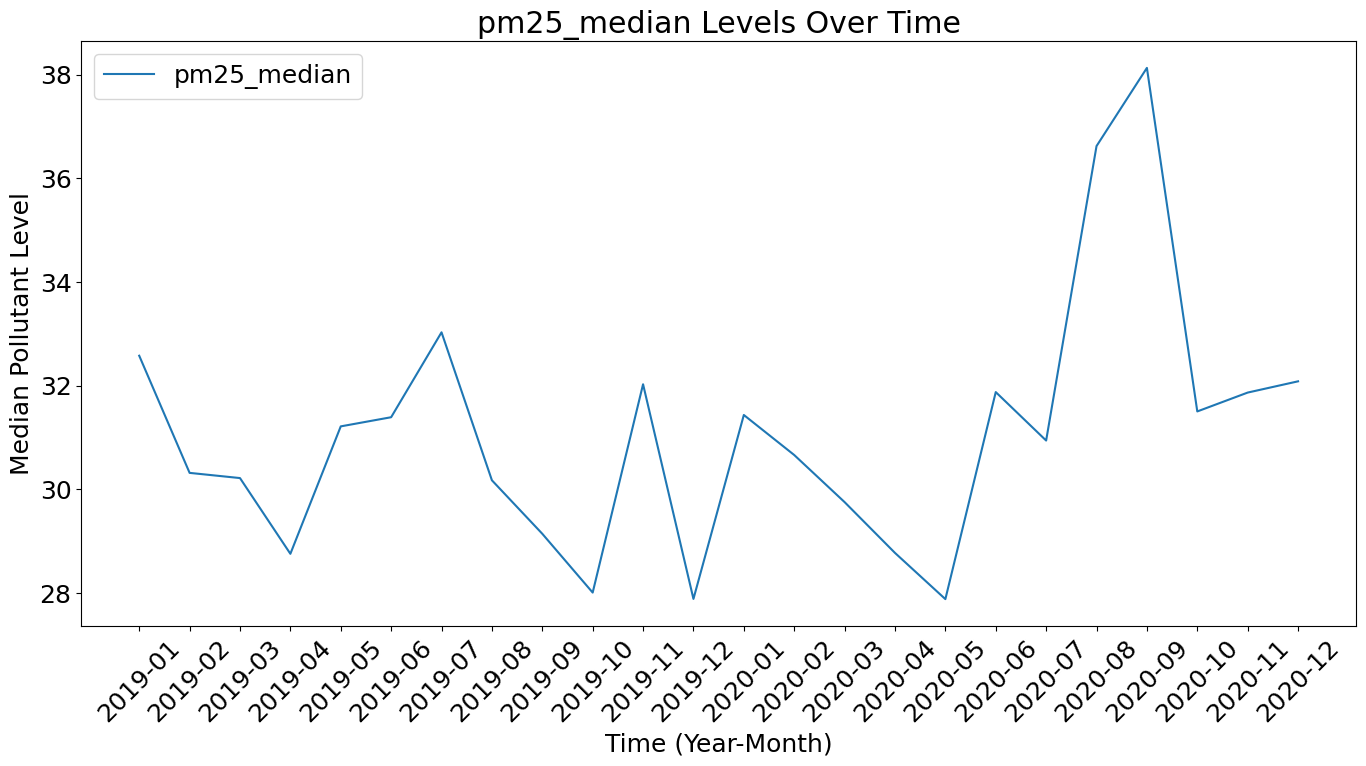

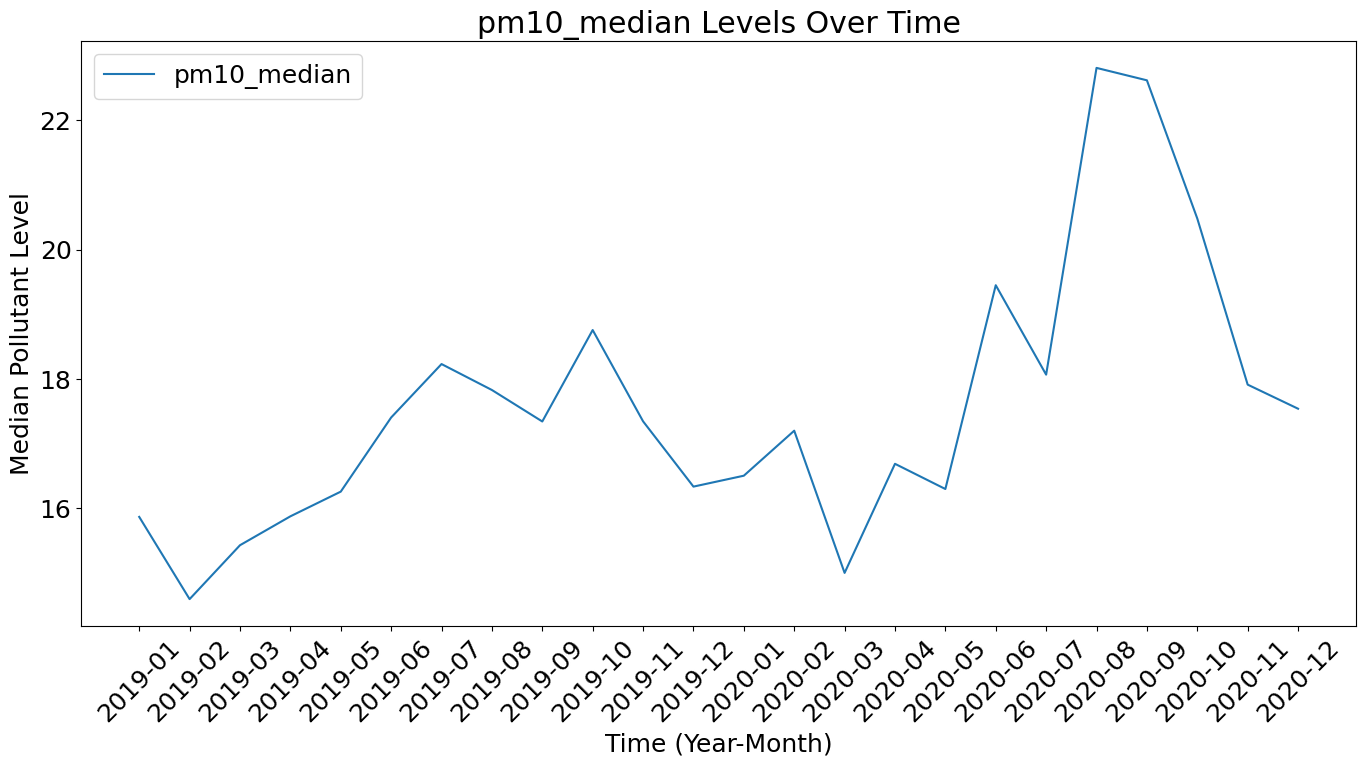

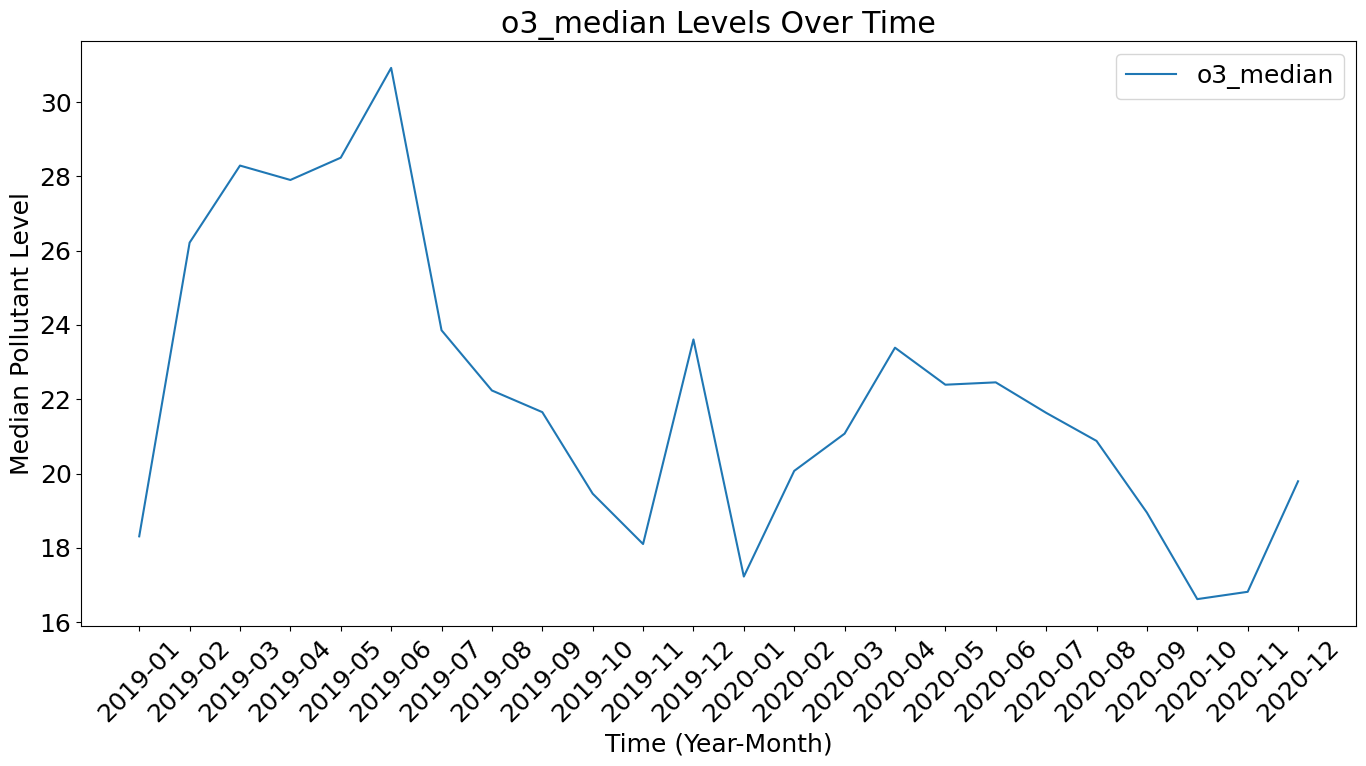

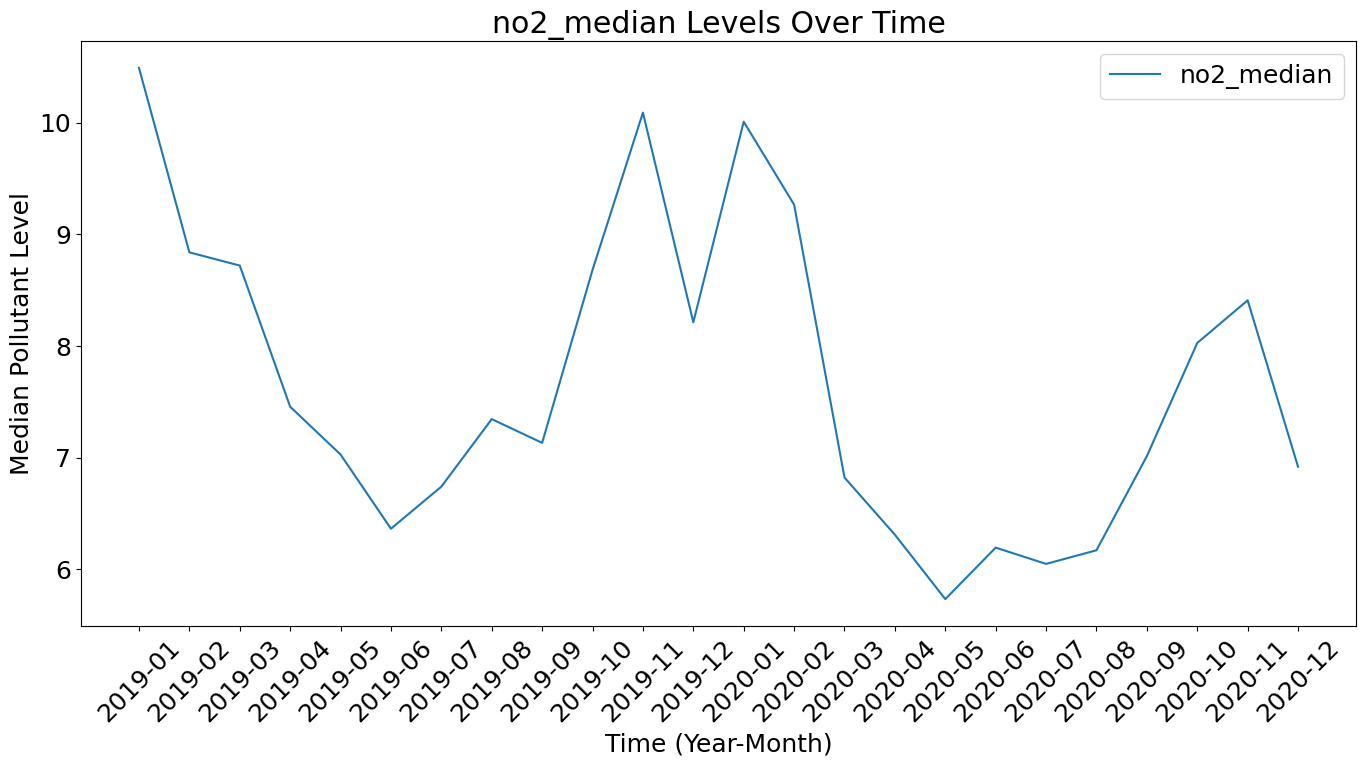

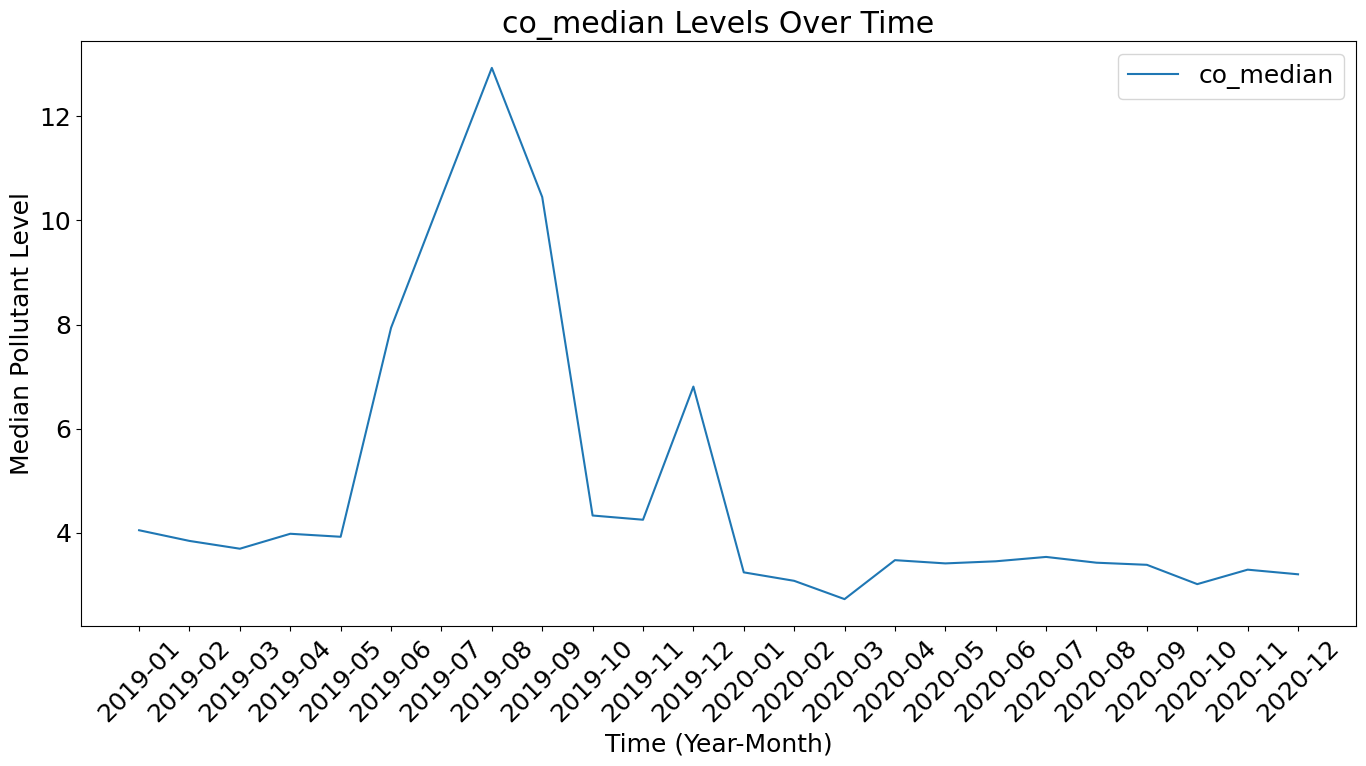

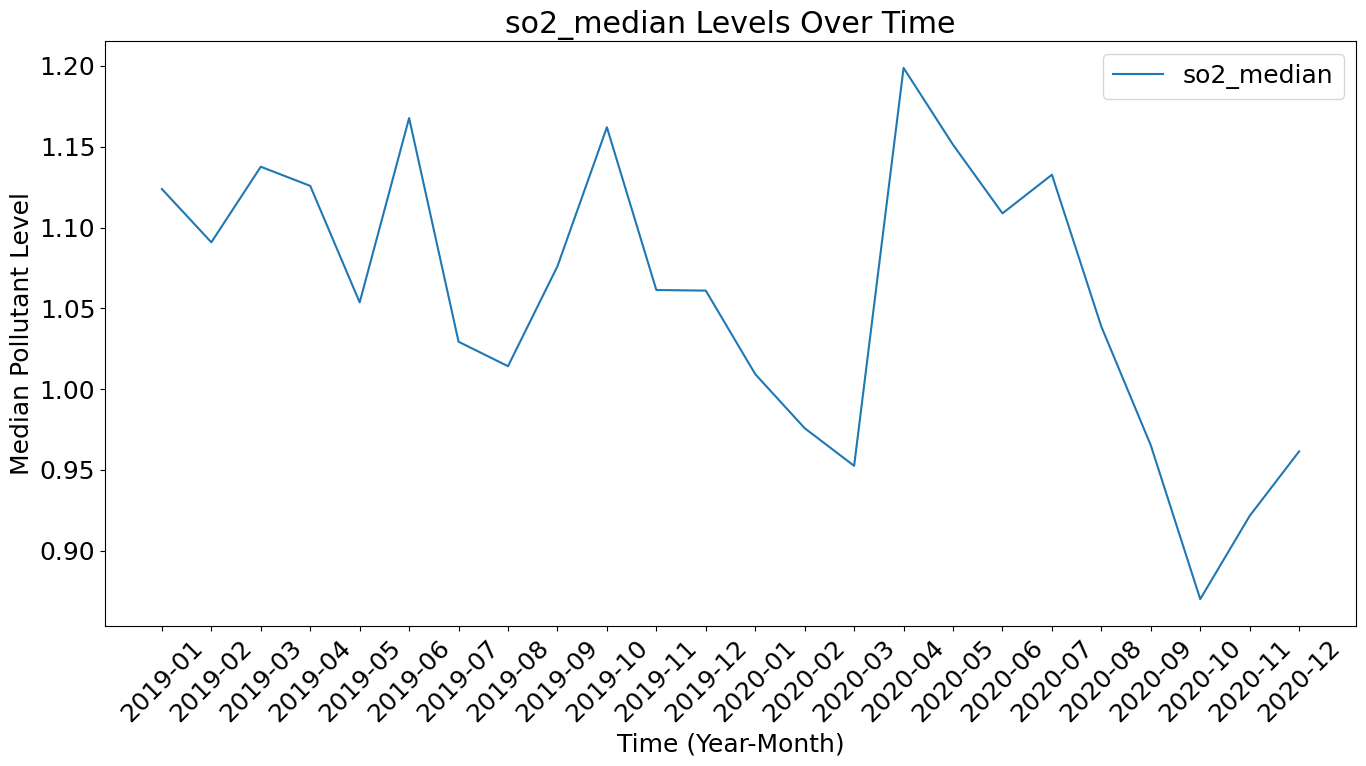

In [ ]:
# data_copy['Date'] = pd.to_datetime(data_copy['Date'])
data_copy['year_month'] = data_copy['Date'].dt.to_period('M')
pollutants = ['pm25_median', 'pm10_median', 'o3_median', 'no2_median','co_median','so2_median']

# Groupby year and month 
monthly_data = data_copy.groupby('year_month')[pollutants].mean().reset_index()
monthly_data['year_month'] = monthly_data['year_month'].astype(str)

# Plot
plt.figure(figsize=(14, 8))
for pollutant in pollutants:
    plt.plot(monthly_data['year_month'], monthly_data[pollutant], label=pollutant)
plt.xlabel('Time (Year-Month)')
plt.ylabel('Median Pollutant Level')
plt.title('Median Pollutant Levels Over Time')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
#plt.show()
plt.savefig("pollution_over_time.png")


# Plot
for pollutant in pollutants:
    plt.figure(figsize=(14, 8))
    plt.plot(monthly_data['year_month'], monthly_data[pollutant], label=pollutant)
    plt.xlabel('Time (Year-Month)')
    plt.ylabel('Median Pollutant Level')
    plt.title(f'{pollutant} Levels Over Time')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    #plt.show()
    plt.savefig(f"pollution_{pollutant}_over_time.png")

## Pre and Post Covid data comparison

THOSE ARE MEANS OF MEDIANS NOT MEDIANS
             Pre-COVID  Post-COVID
pm25_median  29.698080   29.405603
pm10_median  15.535424   16.235482
o3_median    21.090120   20.101330
no2_median    7.043071    6.205698
co_median     2.518574    2.491439
so2_median    0.940137    0.842078

THOSE ARE SUMMATIONS OF MEDIANS
             Pre-COVID  Post-COVID
pm25_median   509797.0    533730.0
pm10_median   134704.0    154276.0
o3_median     394093.2    325535.4
no2_median     88629.7     83546.2
co_median      73991.6     39457.8
so2_median      7417.3      7553.9


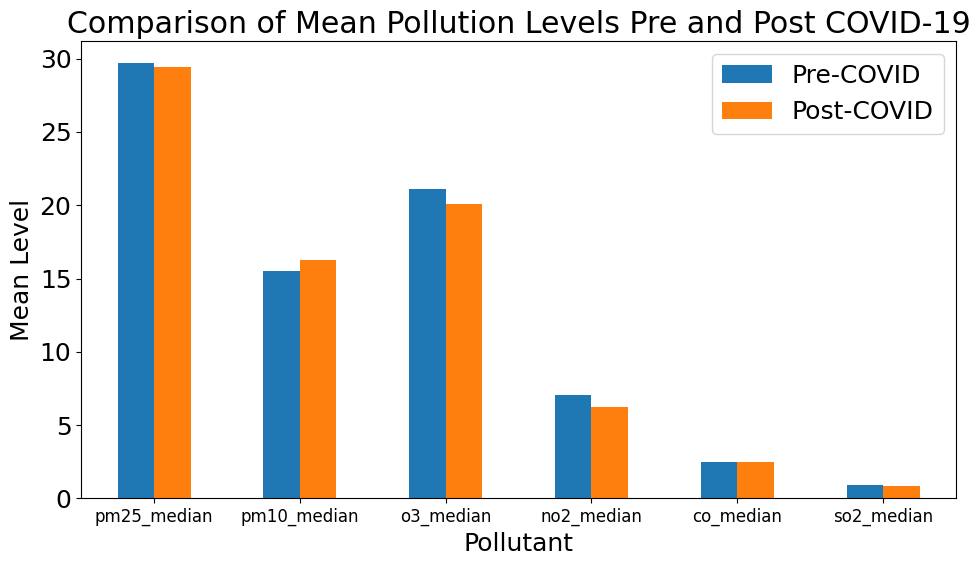

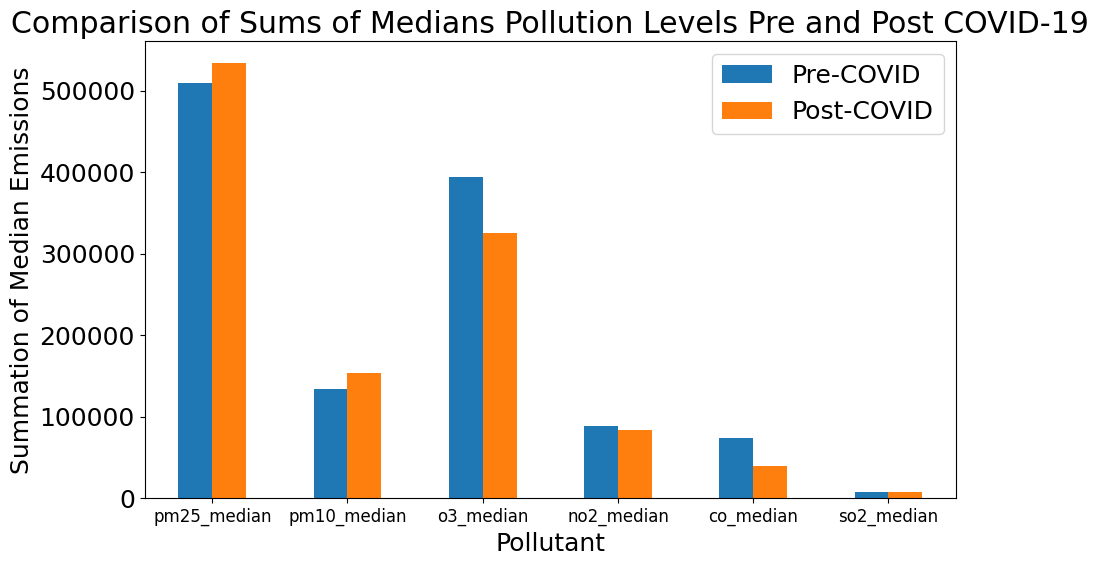

In [ ]:
pre_covid_means = pd.Series()
post_covid_means = pd.Series()
pre_covid_sum_medians = pd.Series()
post_covid_sum_medians = pd.Series()

# input values for graphs
for pollutant in pollutants:
    pre_covid_pollutant, post_covid_pollutant = clean_pre_post_covid(pre_covid, post_covid, pollutant)
    pre_covid_means[pollutant] = pre_covid_pollutant[pollutant].mean()
    post_covid_means[pollutant] = post_covid_pollutant[pollutant].mean()
    pre_covid_sum_medians[pollutant] = pre_covid[pollutant].sum()
    post_covid_sum_medians[pollutant] = post_covid[pollutant].sum()

comparison_df = pd.DataFrame({'Pre-COVID': pre_covid_means, 'Post-COVID': post_covid_means})

print('THOSE ARE MEANS OF MEDIANS NOT MEDIANS')
print(comparison_df)

#Plotting
comparison_df.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Pollutant')
plt.ylabel('Mean Level')
plt.title('Comparison of Mean Pollution Levels Pre and Post COVID-19')
plt.xticks(rotation=0, fontsize = 12)
plt.tight_layout()


comparison_df_sum = pd.DataFrame({'Pre-COVID': pre_covid_sum_medians, 'Post-COVID': post_covid_sum_medians})
print("\nTHOSE ARE SUMMATIONS OF MEDIANS")
print(comparison_df_sum)

#Plotting
comparison_df_sum.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Pollutant')
plt.ylabel('Summation of Median Emissions')
plt.title('Comparison of Sums of Medians Pollution Levels Pre and Post COVID-19')
plt.xticks(rotation=0, fontsize = 12)
plt.tight_layout()
plt.show()

## Kolomogorv-Smirnov test on pre and post covid data

We conducted some Kolomogorv Smirnov Two-Sample tests on pre and post covid data

In [ ]:
for pollutant in pollutants:
    pre_covid_pollutant, post_covid_pollutant = clean_pre_post_covid(pre_covid, post_covid, pollutant) 
    ks_statistics_clean, p_value_clean = stats.ks_2samp(pre_covid_pollutant[pollutant], post_covid_pollutant[pollutant], alternative = 'less')
    print(f"Kolmogorov Smirnov Two-Sample Test statistics for cleaned samples {pollutant}: {ks_statistics_clean}, p-value: {p_value_clean}")
    ks_statistics, p_value = stats.ks_2samp(pre_covid[pollutant], post_covid[pollutant], alternative = 'less')
    print(f"Kolmogorov Smirnov Two-Sample Test statistics for regular samples {pollutant}: {ks_statistics}, p-value: {p_value}\n")

Kolmogorov Smirnov Two-Sample Test statistics for cleaned samples pm25_median: 0.014667925716084329, p-value: 0.03231271032758626
Kolmogorov Smirnov Two-Sample Test statistics for regular samples pm25_median: 0.001769389560601596, p-value: 0.9466261124454822

Kolmogorov Smirnov Two-Sample Test statistics for cleaned samples pm10_median: 0.0014518002322880372, p-value: 0.9855879093169098
Kolmogorov Smirnov Two-Sample Test statistics for regular samples pm10_median: 0.01969920377469775, p-value: 0.0013614114799540692

Kolmogorov Smirnov Two-Sample Test statistics for cleaned samples o3_median: 0.05535590441964566, p-value: 7.381907403671366e-22
Kolmogorov Smirnov Two-Sample Test statistics for regular samples o3_median: 0.04966086700088468, p-value: 6.586393203754317e-19

Kolmogorov Smirnov Two-Sample Test statistics for cleaned samples no2_median: 0.07992039384099717, p-value: 3.0915086043998124e-27
Kolmogorov Smirnov Two-Sample Test statistics for regular samples no2_median: 0.06352108

## Geolocation Analysis

We plotted our data onto the USA map to check for any geolocation trends and identify any potential patterns.

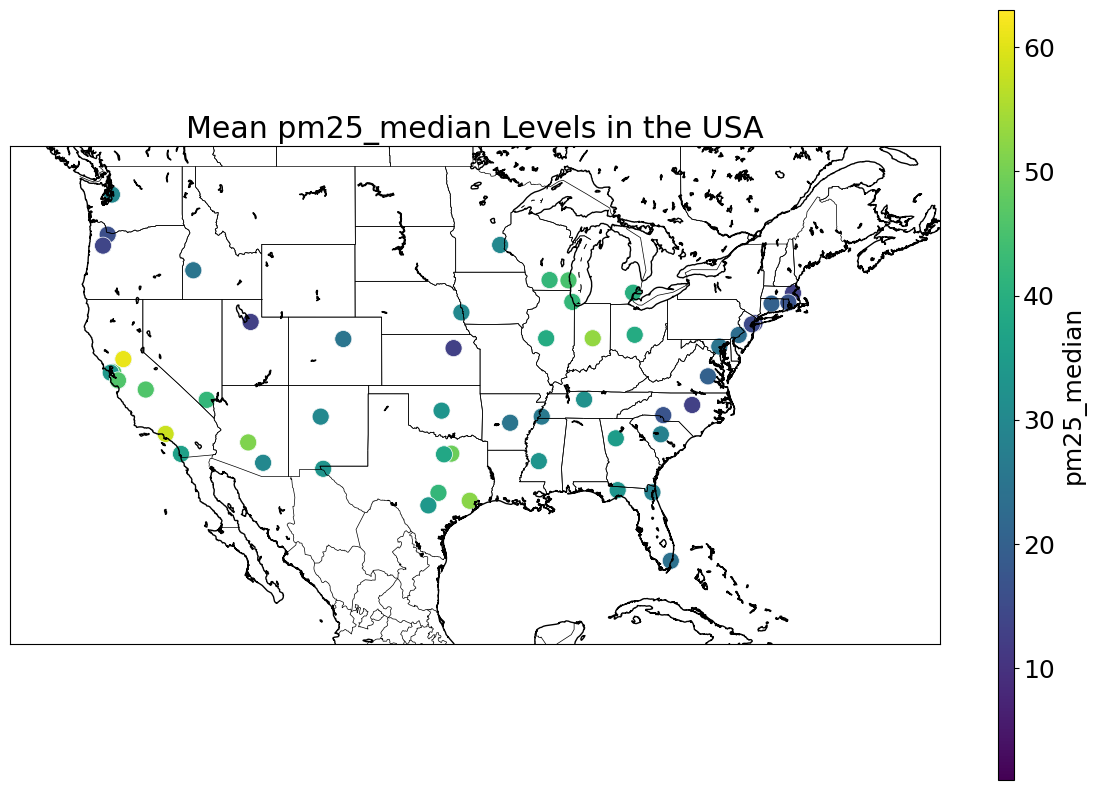

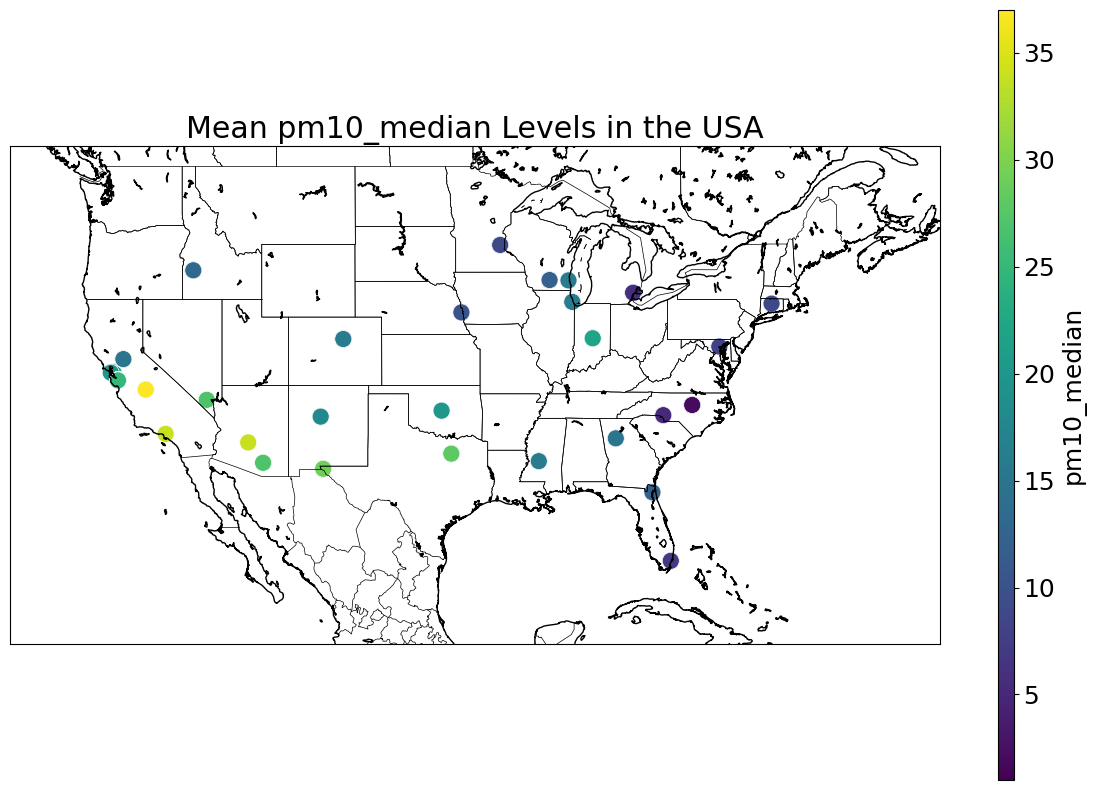

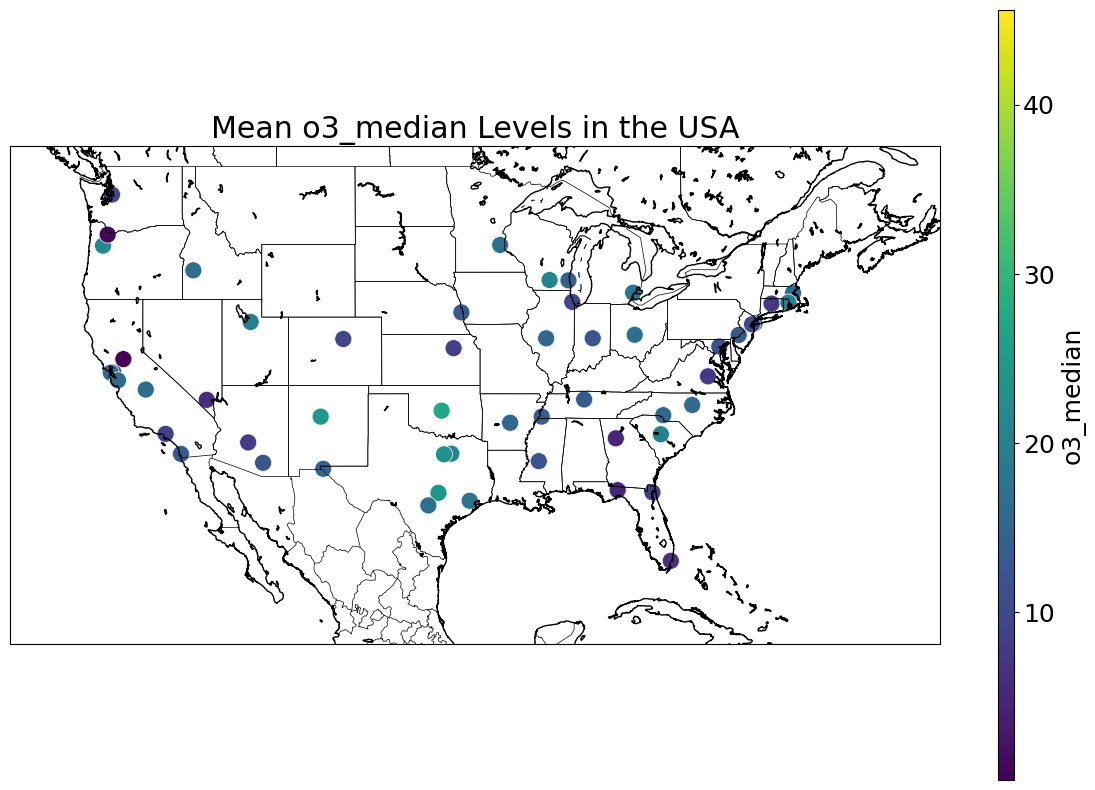

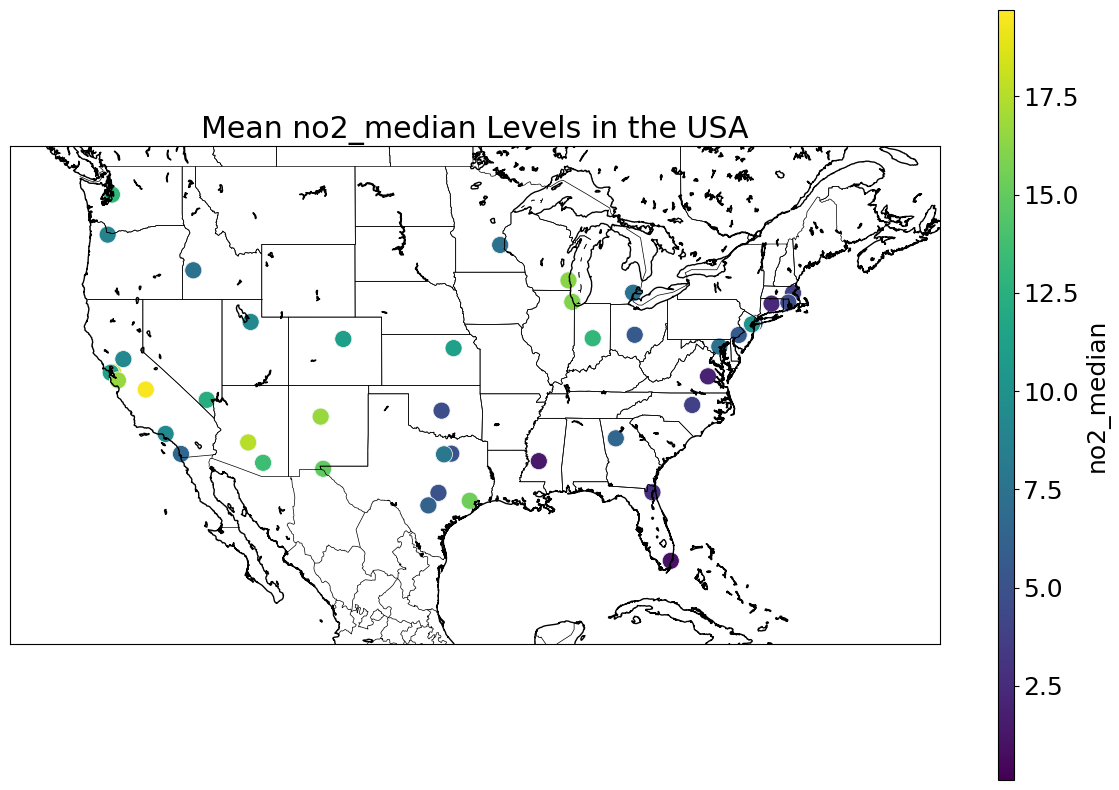

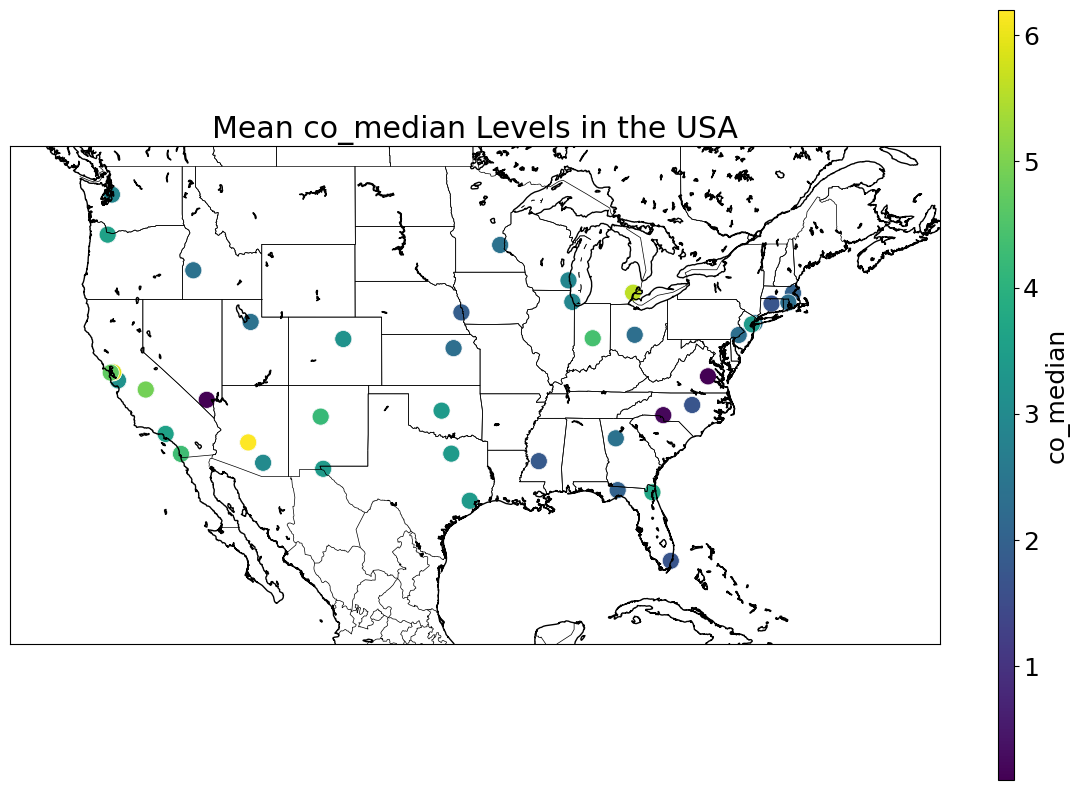

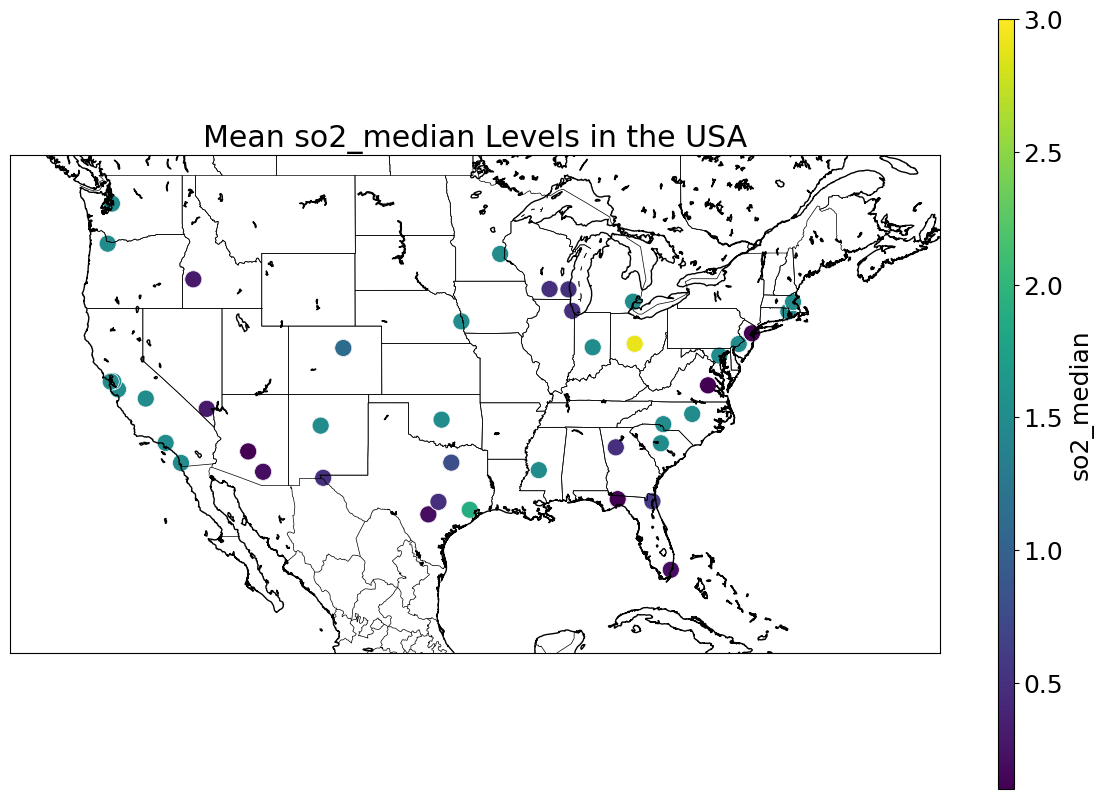

In [ ]:
from mpl_toolkits.basemap import Basemap
pollutants = ['pm25_median', 'pm10_median', 'o3_median', 'no2_median','co_median','so2_median']

# Plotting the pollutant data on the map with correct color normalization
def plot_pollutant_basemap(data, pollutant, title):
    fig, ax = plt.subplots(figsize=(15, 10))
    m = Basemap(projection='merc', llcrnrlat=20, urcrnrlat=50, llcrnrlon=-130, urcrnrlon=-60, resolution='i')
    m.drawcoastlines()
    m.drawcountries()
    m.drawstates()

    norm = plt.Normalize(vmin=data[pollutant].min(), vmax=data[pollutant].max())
    sc = m.scatter(data['longitude'].values, data['latitude'].values, latlon=True, c=data[pollutant], cmap='viridis',
                   s=150, alpha=1, edgecolors='w', linewidth=0.5, norm=norm)

    cbar = plt.colorbar(sc, ax=ax, orientation='vertical', pad=0.05, aspect=50)
    cbar.set_label(pollutant)

    plt.title(title)
    plt.savefig(f'{pollutant}_usa_map.png')
    plt.show()

for pollutant in pollutants:
    plot_data = clean_features(data, ['longitude', 'latitude'], pollutant)
    plot_pollutant_basemap(plot_data, f'{pollutant}', f'Mean {pollutant} Levels in the USA')


# Regression Models

## Random Forest Regressor


 pm25_median Random Forest Root Mean Squared Error: 10.354656440451068
pm25_median Random Forest Mean Absolute Percentage Error: 0.3343678813761519


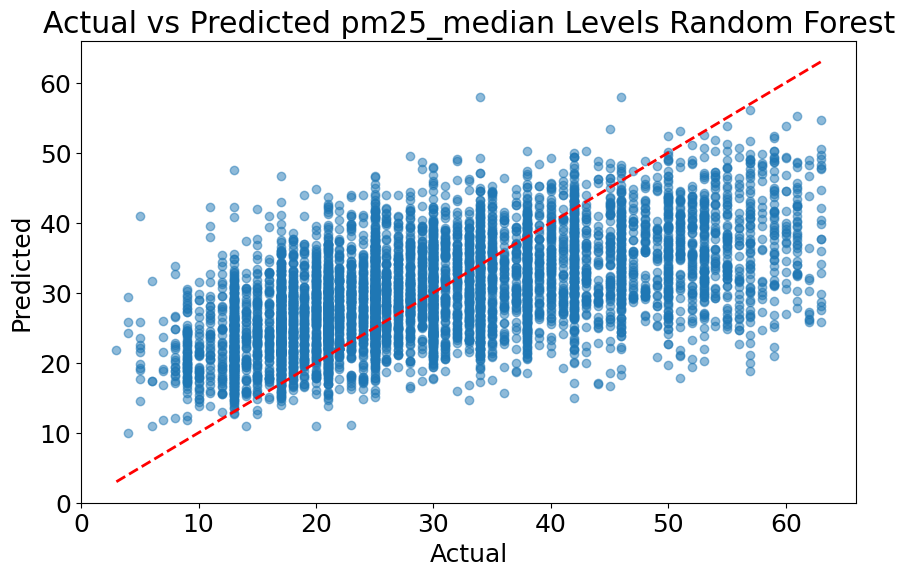

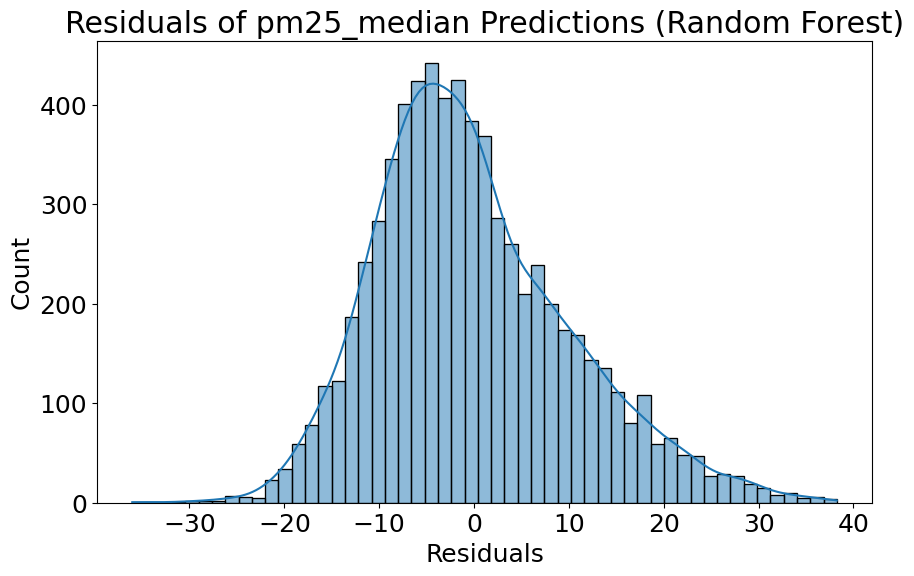

Cross-Validation RMSE scores: [10.40237458 10.10100588 10.30755689 10.36258564 10.39429141]
Mean Cross-Validation RMSE score: 10.313562877736409
Cross-Validation MAPE scores: [0.33541792 0.32647813 0.32863798 0.33597153 0.33223582]
Mean Cross-Validation MAPE score: 0.3317482775801326

 pm10_median Random Forest Root Mean Squared Error: 5.334237407628037
pm10_median Random Forest Mean Absolute Percentage Error: 0.33731732865470293


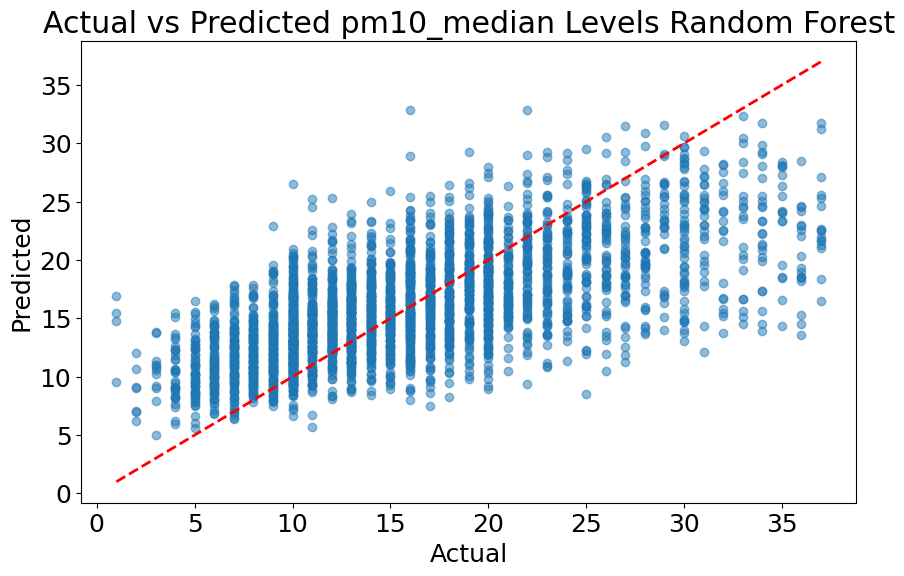

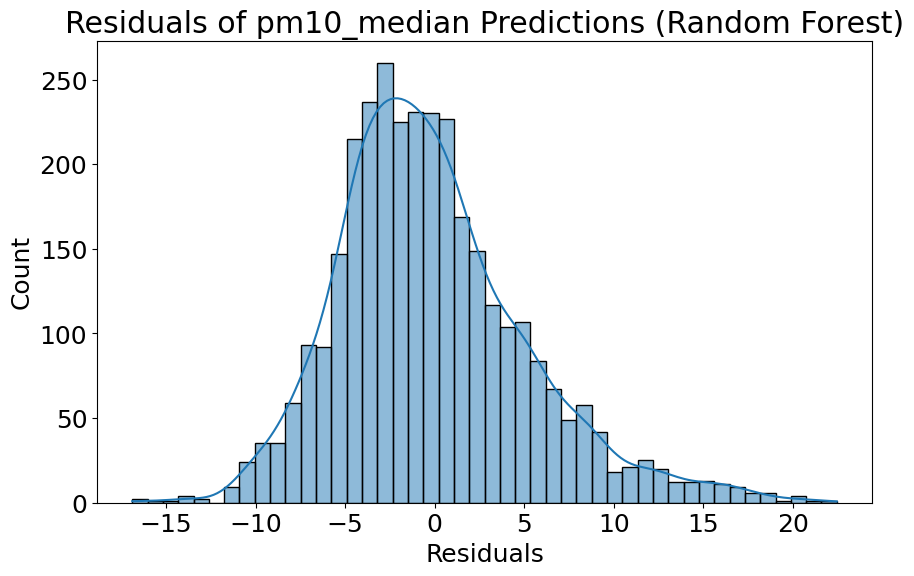

Cross-Validation RMSE scores: [5.50393151 5.44632421 5.5270448  5.55385977 5.5663179 ]
Mean Cross-Validation RMSE score: 5.519495638474003
Cross-Validation MAPE scores: [0.3443979  0.33975414 0.32610909 0.33309263 0.36170876]
Mean Cross-Validation MAPE score: 0.3410125023870191

 o3_median Random Forest Root Mean Squared Error: 5.48545874378163
o3_median Random Forest Mean Absolute Percentage Error: 1.1807183584776708


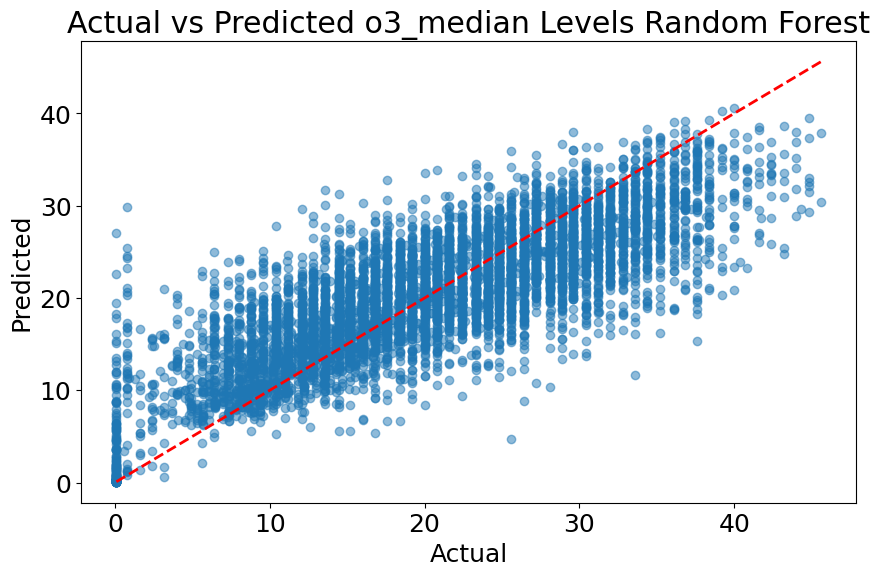

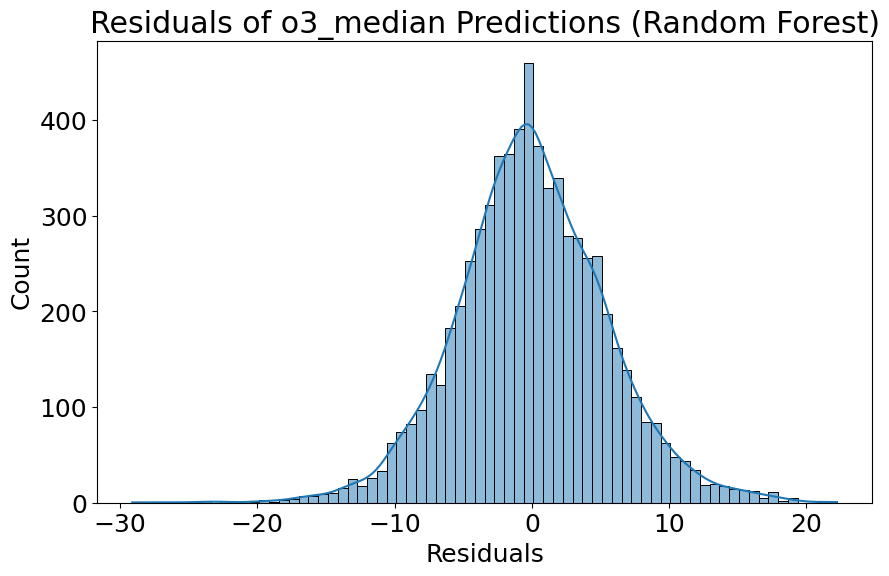

Cross-Validation RMSE scores: [5.47628779 5.41831194 5.4349836  5.44574646 5.42145091]
Mean Cross-Validation RMSE score: 5.439356141009066
Cross-Validation MAPE scores: [1.18700786 0.95206335 1.23000855 0.94993544 0.85708283]
Mean Cross-Validation MAPE score: 1.0352196038651287

 no2_median Random Forest Root Mean Squared Error: 2.924676834693613
no2_median Random Forest Mean Absolute Percentage Error: 0.47757676057300663


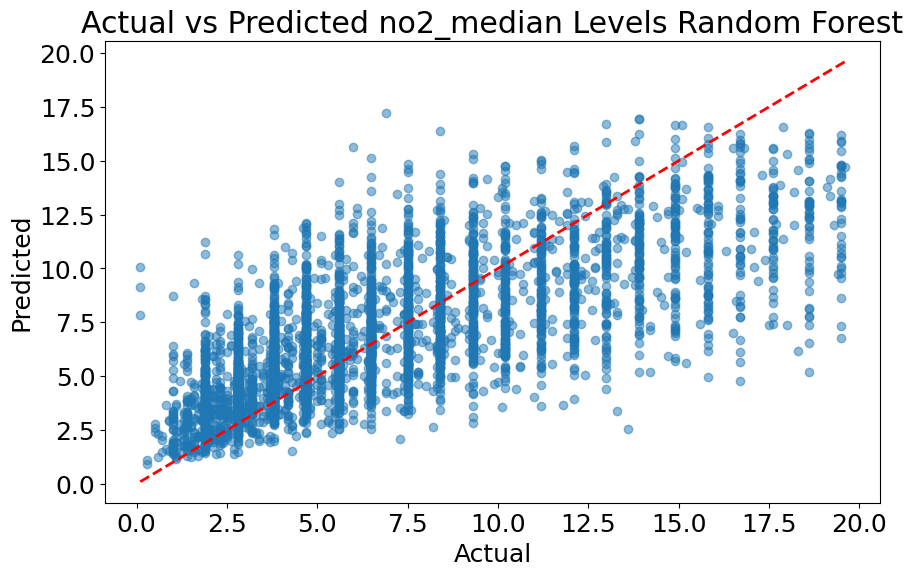

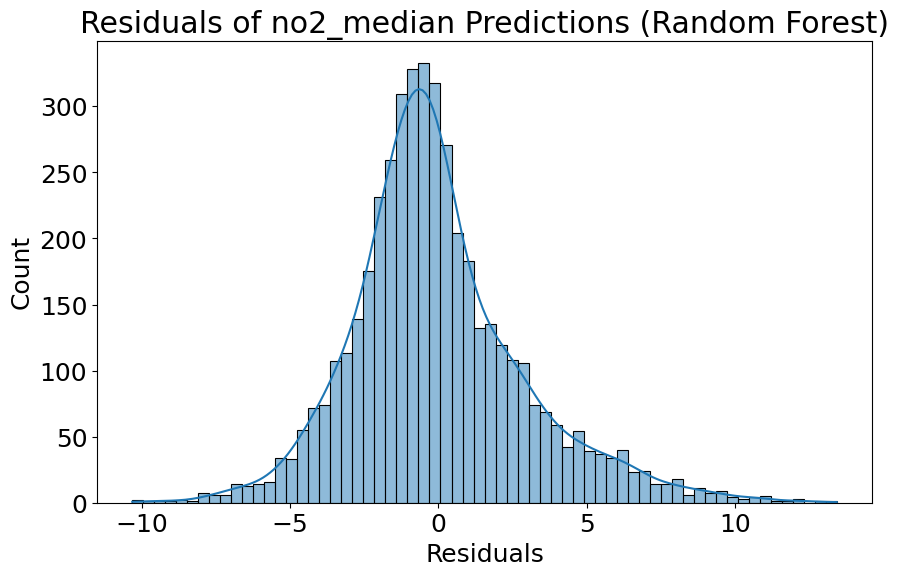

Cross-Validation RMSE scores: [2.90468093 2.93388731 2.95108737 2.90905708 2.95564817]
Mean Cross-Validation RMSE score: 2.9308721737301604
Cross-Validation MAPE scores: [0.50663867 0.45680316 0.45633933 0.42537091 0.42685347]
Mean Cross-Validation MAPE score: 0.45440111027414387

 co_median Random Forest Root Mean Squared Error: 0.7635352634175968
co_median Random Forest Mean Absolute Percentage Error: 0.3722434998559509


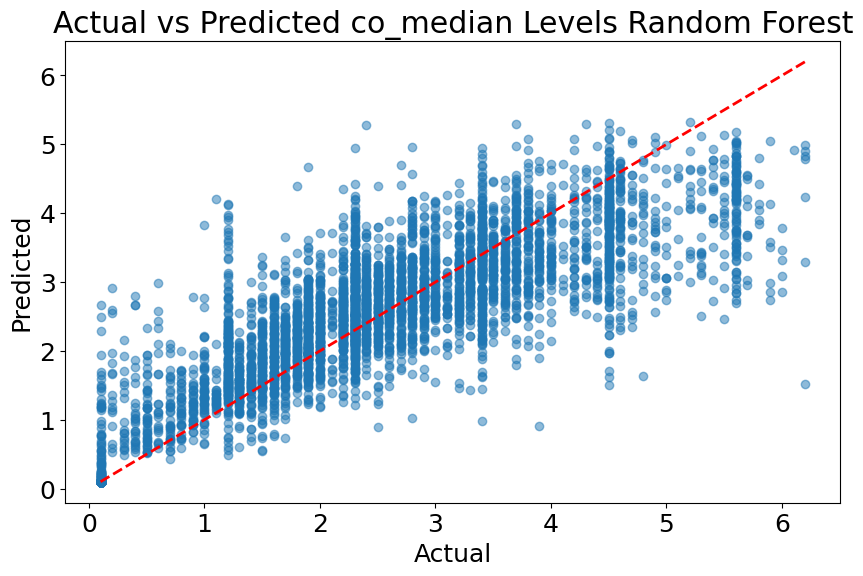

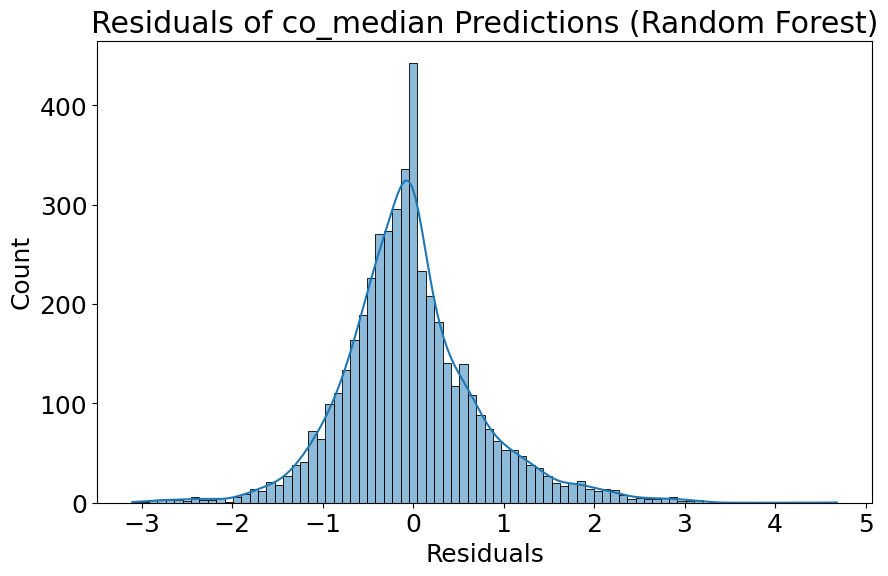

Cross-Validation RMSE scores: [0.76667725 0.76027495 0.77149488 0.77733809 0.76727941]
Mean Cross-Validation RMSE score: 0.7686129163532167
Cross-Validation MAPE scores: [0.38147448 0.37128678 0.37528596 0.39915153 0.37786255]
Mean Cross-Validation MAPE score: 0.3810122573556077


In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_percentage_error

pollutants = ['pm25_median', 'pm10_median', 'o3_median', 'no2_median','co_median']

features = ['humidity_median', 'wind-gust_median', 'wind-speed_median', 'temperature_median', 'dew_median', 'pp_feat', 'total_population']
#target = 'no2_median'

plt.rcParams.update({'font.size': 18})

for target in pollutants:
    # Remove outliers
    clean_data = clean_features(data_copy, features, target)
    
    # target and features
    X_pre = clean_data[features]
    y_pre = clean_data[target]
    
    # NaN handling
    X_pre = X_pre.fillna(X_pre.mean())
    
    # Standardize features
    scaler = StandardScaler()
    X_pre_scaled = scaler.fit_transform(X_pre)
    
    # Add polynomial features
    poly = PolynomialFeatures(degree=2, include_bias=False)
    X_pre_poly = poly.fit_transform(X_pre_scaled)
    
    # Intercept (for bias etc idk)
    X_pre_poly = sm.add_constant(X_pre_poly)
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_pre_poly, y_pre, test_size=0.2, random_state=42)
    
    # Random Forest model with chosen hyperparameters
    best_rf = RandomForestRegressor(
        n_estimators=200,
        max_depth=20,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs = -1
    )
    best_rf.fit(X_train, y_train)
    
    # Predictions and evaluation
    rf_pred = best_rf.predict(X_test)
    rf_mse = mean_squared_error(y_test, rf_pred)
    rf_mape = mean_absolute_percentage_error(y_test, rf_pred)
    print(f"\n {target} Random Forest Root Mean Squared Error:", np.sqrt(rf_mse))
    print(f"{target} Random Forest Mean Absolute Percentage Error:", rf_mape)
    
    # Plotting actual vs predicted values
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, rf_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'Actual vs Predicted {target} Levels Random Forest')
    plt.savefig(f"Actual_vs_Predicted_{target}_Levels_Random_Forest.png")
    plt.show()
    
    # Plotting residuals
    rf_residuals = y_test - rf_pred
    plt.figure(figsize=(10, 6))
    sns.histplot(rf_residuals, kde=True)
    plt.xlabel('Residuals')
    plt.title(f'Residuals of {target} Predictions (Random Forest)')
    plt.savefig(f"Residuals_of_{target}_Predictions_Random_Forest.png")
    plt.show()
    
    def rmse(y_true, y_pred):
        return np.sqrt(mean_squared_error(y_true, y_pred))
    
    # scorer objects
    rmse_scorer = make_scorer(rmse, greater_is_better=False)
    mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)
    
    #cross-validation scores
    rmse_cv_scores = cross_val_score(best_rf, X_train, y_train, cv=5, scoring=rmse_scorer)
    print("Cross-Validation RMSE scores:", -rmse_cv_scores)
    print("Mean Cross-Validation RMSE score:", -rmse_cv_scores.mean())
    
    mape_cv_scores = cross_val_score(best_rf, X_train, y_train, cv=5, scoring=mape_scorer)
    print("Cross-Validation MAPE scores:", -mape_cv_scores)
    print("Mean Cross-Validation MAPE score:", -mape_cv_scores.mean())


## Gradient Boosting Regressor


 pm25_median XGBoost Root Mean Squared Error: 10.246600573531252
pm25_median XGBoost Mean Absolute Percentage Error: 0.32746189574705636


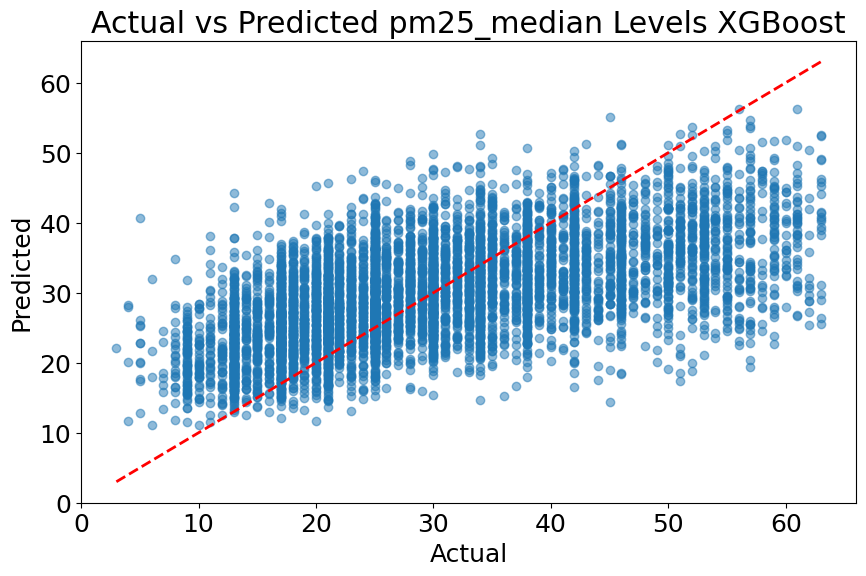

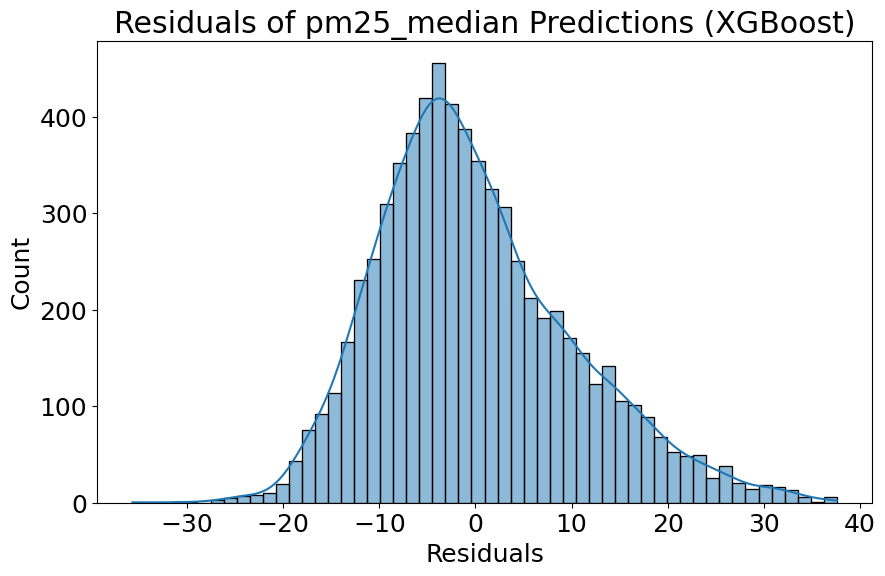

Cross-Validation RMSE scores: [10.31969779 10.02752846 10.29431311 10.27506007 10.22937181]
Mean Cross-Validation RMSE score: 10.22919424828082
Cross-Validation MAPE scores: [0.32834671 0.32109566 0.3237204  0.32989854 0.3248016 ]
Mean Cross-Validation MAPE score: 0.32557258274420897

 pm10_median XGBoost Root Mean Squared Error: 5.331553115471452
pm10_median XGBoost Mean Absolute Percentage Error: 0.33596392457289187


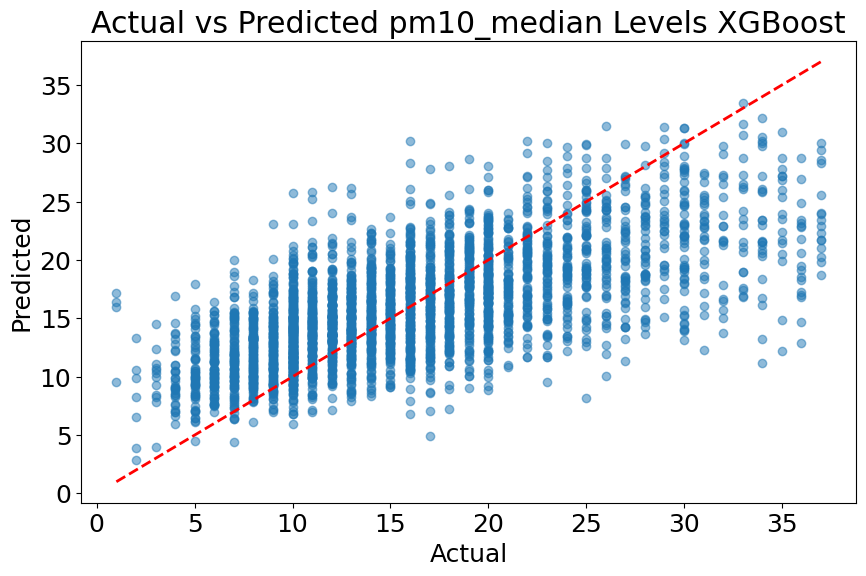

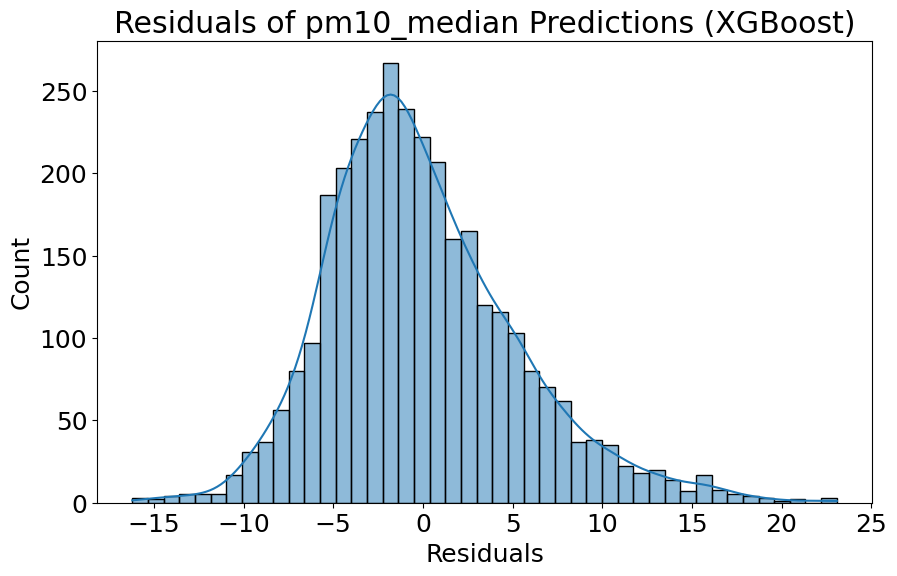

Cross-Validation RMSE scores: [5.48364473 5.38980217 5.49600756 5.49090241 5.53894048]
Mean Cross-Validation RMSE score: 5.479859470577283
Cross-Validation MAPE scores: [0.3411399  0.33048019 0.31745513 0.32499667 0.35797414]
Mean Cross-Validation MAPE score: 0.3344092061454652

 o3_median XGBoost Root Mean Squared Error: 5.439032854581776
o3_median XGBoost Mean Absolute Percentage Error: 1.14021379363238


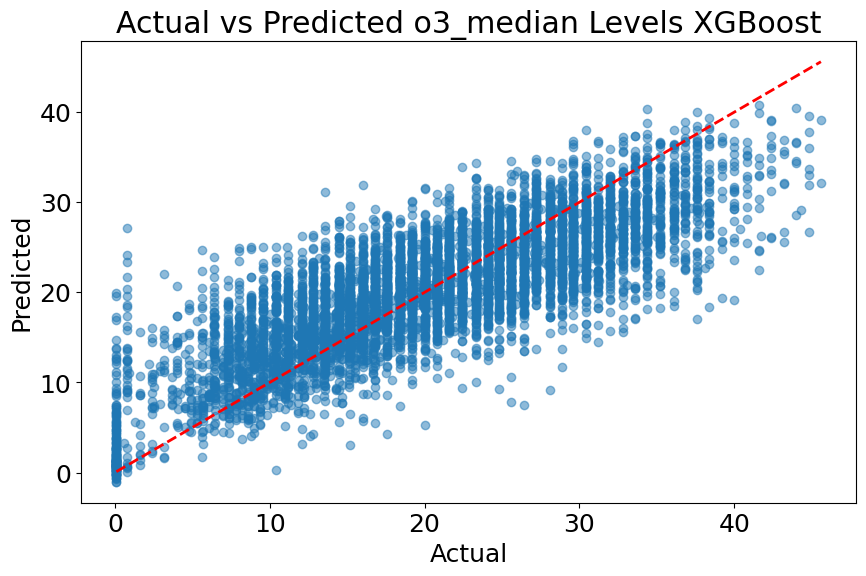

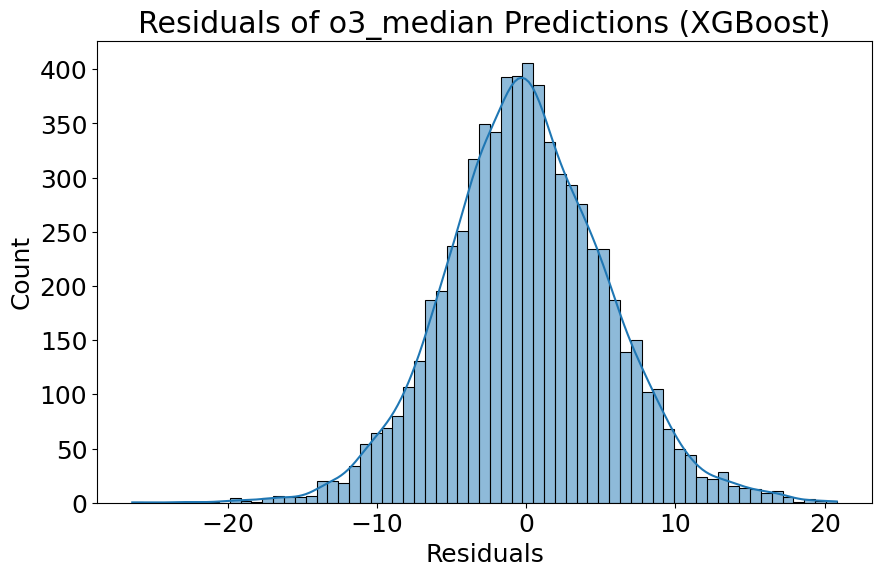

Cross-Validation RMSE scores: [5.38929263 5.33919243 5.32186868 5.34255046 5.2985543 ]
Mean Cross-Validation RMSE score: 5.338291701847536
Cross-Validation MAPE scores: [1.07166781 0.92452989 1.11039245 0.83343277 0.81526435]
Mean Cross-Validation MAPE score: 0.9510574537779677

 no2_median XGBoost Root Mean Squared Error: 2.8791263752318494
no2_median XGBoost Mean Absolute Percentage Error: 0.46895335866094834


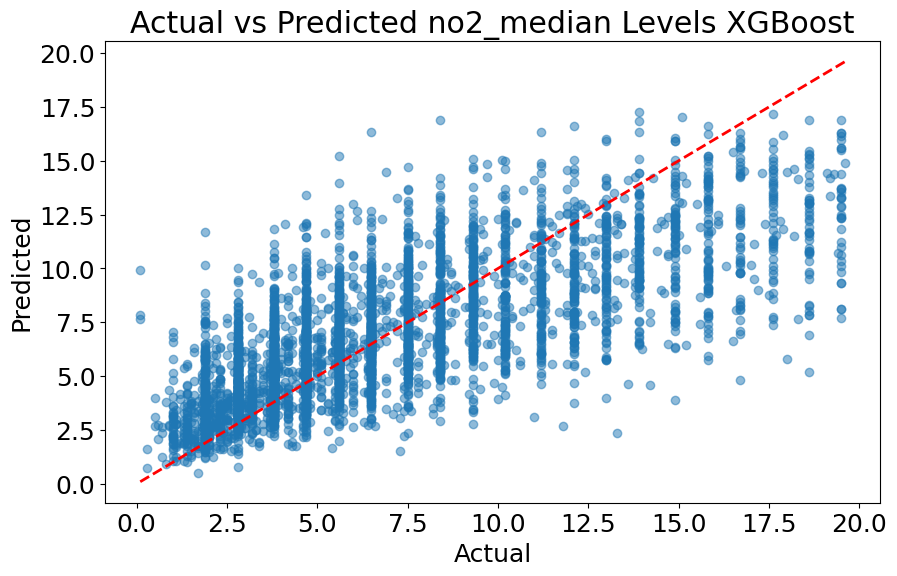

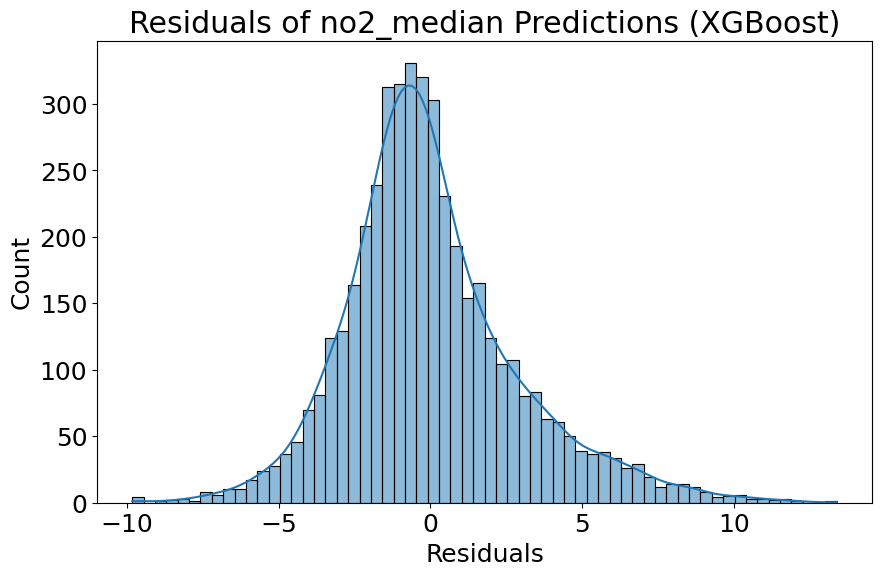

Cross-Validation RMSE scores: [2.86229271 2.9034521  2.89135104 2.83170332 2.91822628]
Mean Cross-Validation RMSE score: 2.8814050888401423
Cross-Validation MAPE scores: [0.4909063  0.44878643 0.44338039 0.41264476 0.41823245]
Mean Cross-Validation MAPE score: 0.4427900662633137

 co_median XGBoost Root Mean Squared Error: 0.7659729112717727
co_median XGBoost Mean Absolute Percentage Error: 0.4167327867913864


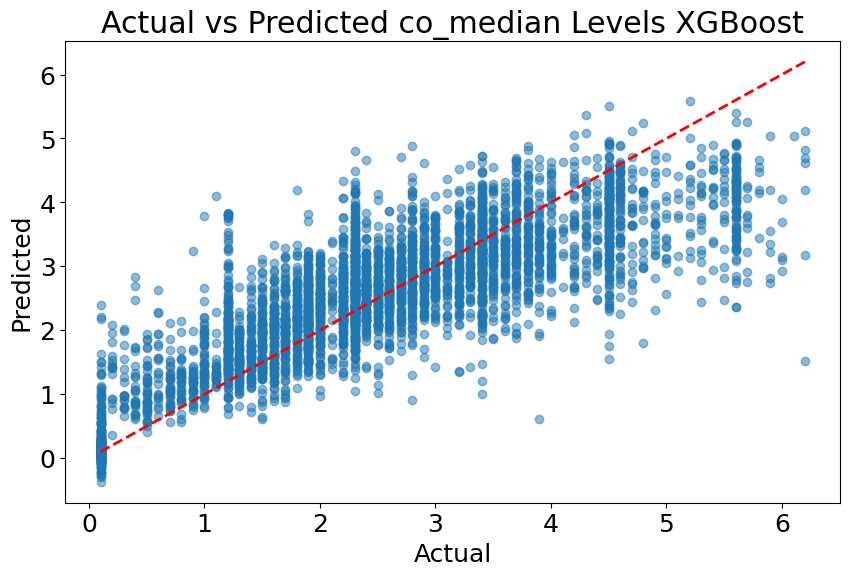

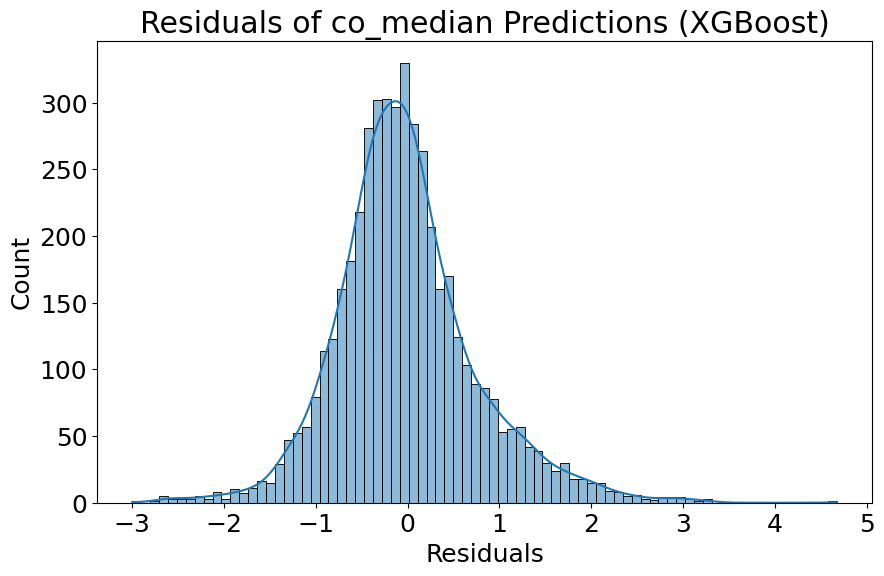

Cross-Validation RMSE scores: [0.77868818 0.75248672 0.77355155 0.77839783 0.77735591]
Mean Cross-Validation RMSE score: 0.7720960379115053
Cross-Validation MAPE scores: [0.43054553 0.38675391 0.43435062 0.44385656 0.42719717]
Mean Cross-Validation MAPE score: 0.4245407590221201


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score
from xgboost import XGBRegressor
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

pollutants = ['pm25_median', 'pm10_median', 'o3_median', 'no2_median', 'co_median']

features = ['humidity_median', 'wind-gust_median', 'wind-speed_median', 'temperature_median', 'dew_median', 'pp_feat', 'total_population']
#target = 'no2_median'

plt.rcParams.update({'font.size': 18})

for target in pollutants:
    #Removing outliers
    clean_data = clean_features(data_copy, features, target)
    
    # target and features
    X_pre = clean_data[features]
    y_pre = clean_data[target]
    
    # NaN handling
    X_pre = X_pre.fillna(X_pre.mean())
    
    # Standardize features
    scaler = StandardScaler()
    X_pre_scaled = scaler.fit_transform(X_pre)
    
    # Add polynomial features
    poly = PolynomialFeatures(degree=2, include_bias=False)
    X_pre_poly = poly.fit_transform(X_pre_scaled)
    
    # Intercept (for bias etc idk)
    X_pre_poly = sm.add_constant(X_pre_poly)
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_pre_poly, y_pre, test_size=0.2, random_state=42)
    
    # XGBoost model
    best_xgb = XGBRegressor(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=5,
        min_child_weight=2,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )
    best_xgb.fit(X_train, y_train)
    
    # Predictions and evaluation
    xgb_pred = best_xgb.predict(X_test)
    xgb_mse = mean_squared_error(y_test, xgb_pred)
    xgb_mape = mean_absolute_percentage_error(y_test, xgb_pred)
    print(f"\n {target} XGBoost Root Mean Squared Error:", np.sqrt(xgb_mse))
    print(f"{target} XGBoost Mean Absolute Percentage Error:", xgb_mape)

    # Plotting actual vs predicted values
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, xgb_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'Actual vs Predicted {target} Levels XGBoost')
    plt.savefig(f"Actual_vs_Predicted_{target}_Levels_XGBoost.png")
    plt.show()
    
    # Plotting residuals
    xgb_residuals = y_test - xgb_pred
    plt.figure(figsize=(10, 6))
    sns.histplot(xgb_residuals, kde=True)
    plt.xlabel('Residuals')
    plt.title(f'Residuals of {target} Predictions (XGBoost)')
    plt.savefig(f"Residuals_of_{target}_Predictions_XGBoost.png")
    plt.show()
    
    def rmse(y_true, y_pred):
        return np.sqrt(mean_squared_error(y_true, y_pred))
    
    # scorer objects
    rmse_scorer = make_scorer(rmse, greater_is_better=False)
    mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)
    
    # Cross-validation scores
    rmse_cv_scores = cross_val_score(best_xgb, X_train, y_train, cv=5, scoring=rmse_scorer)
    print("Cross-Validation RMSE scores:", -rmse_cv_scores)
    print("Mean Cross-Validation RMSE score:", -rmse_cv_scores.mean())
    
    mape_cv_scores = cross_val_score(best_xgb, X_train, y_train, cv=5, scoring=mape_scorer)
    print("Cross-Validation MAPE scores:", -mape_cv_scores)
    print("Mean Cross-Validation MAPE score:", -mape_cv_scores.mean())


## Support Vector Regression


 pm25_median SVR Root Mean Squared Error:  11.263533759313544
pm25_median SVR Mean Absolute Percentage Error: 0.33920244304509806


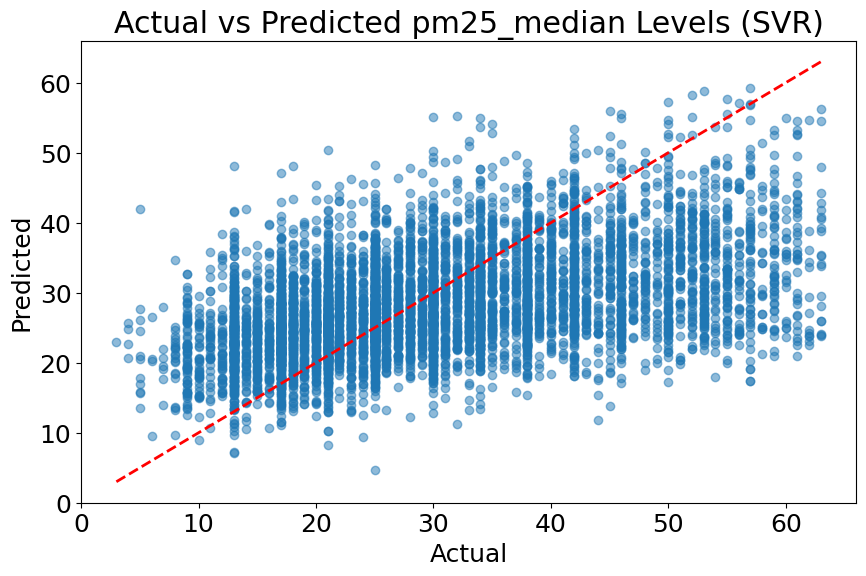

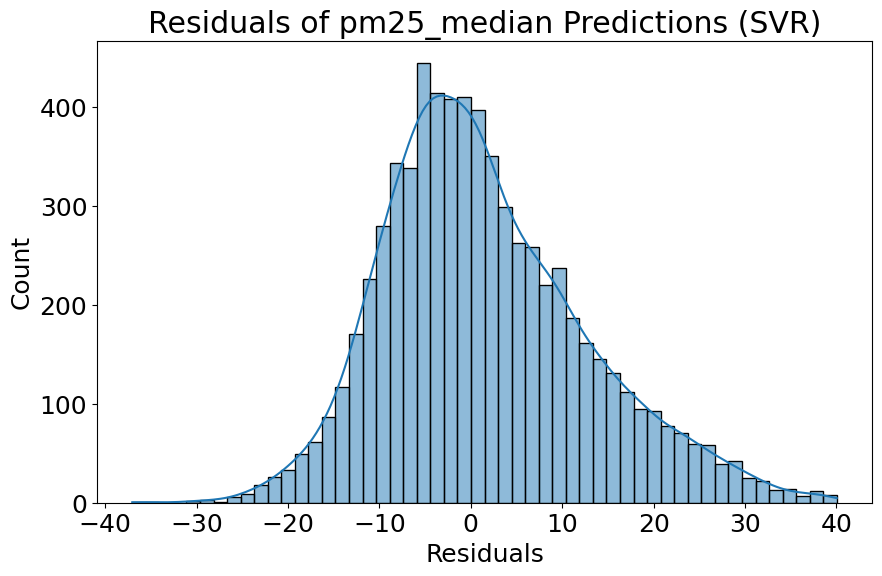


Cross-Validation RMSE scores for pm25_median: [11.24235165 10.94005724 11.22733289 11.07290601 11.07419147]
Mean Cross-Validation RMSE score for pm25_median: 11.111367850635407
Cross-Validation MAPE scores for pm25_median: [0.33916234 0.32678338 0.33175587 0.33359898 0.3281165 ]
Mean Cross-Validation MAPE score for pm25_median: 0.3318834155268592

 pm10_median SVR Root Mean Squared Error:  5.799475740071591
pm10_median SVR Mean Absolute Percentage Error: 0.34720433290220076


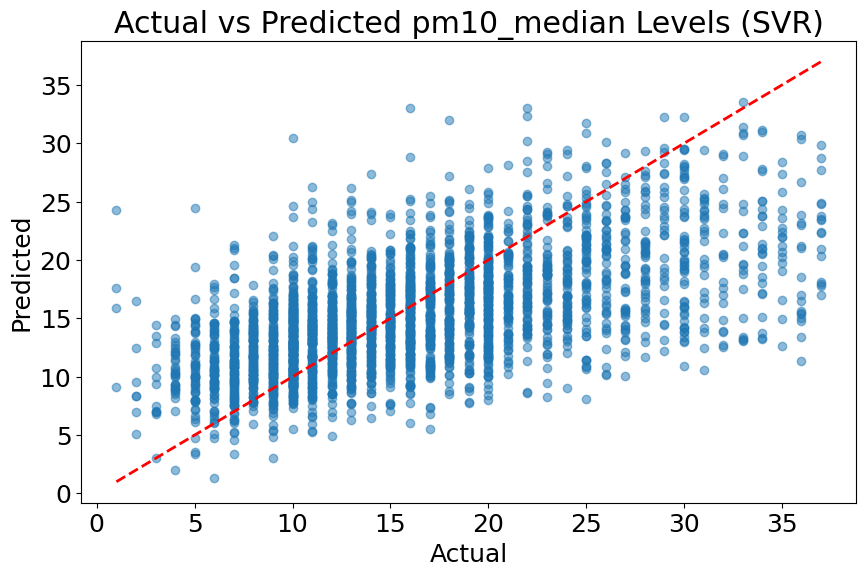

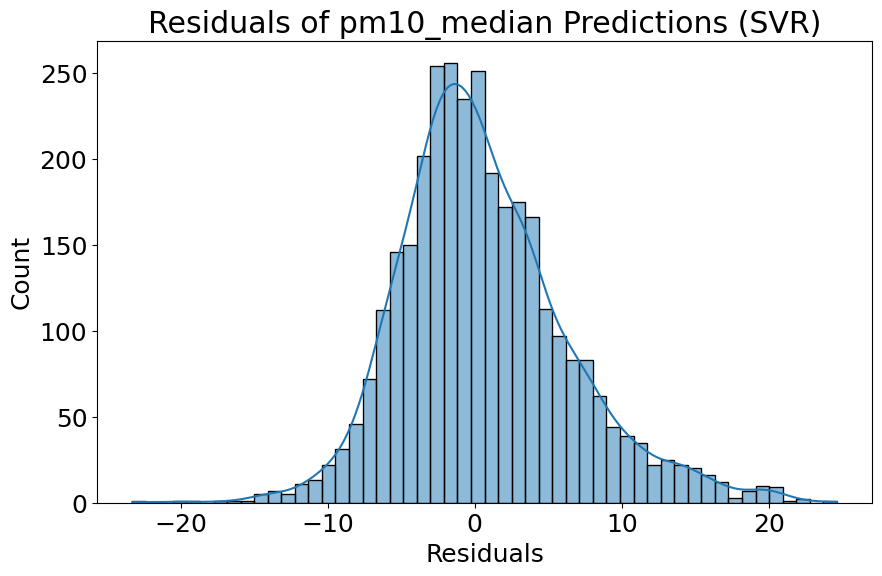


Cross-Validation RMSE scores for pm10_median: [5.90753255 5.8476947  5.99224362 6.00879696 5.83792311]
Mean Cross-Validation RMSE score for pm10_median: 5.918838189167618
Cross-Validation MAPE scores for pm10_median: [0.34179321 0.3392649  0.32933161 0.33771779 0.35652908]
Mean Cross-Validation MAPE score for pm10_median: 0.3409273190183504

 o3_median SVR Root Mean Squared Error:  7.192053083822643
o3_median SVR Mean Absolute Percentage Error: 4.29398554560336


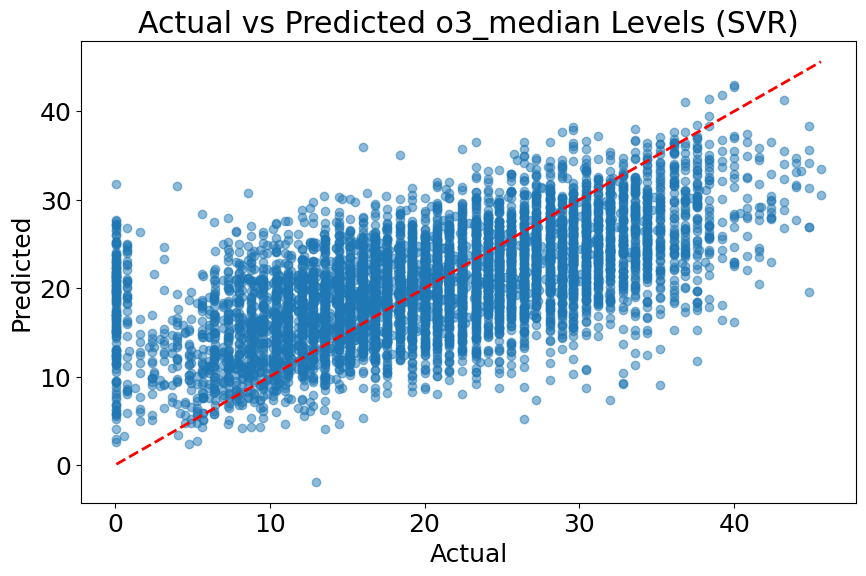

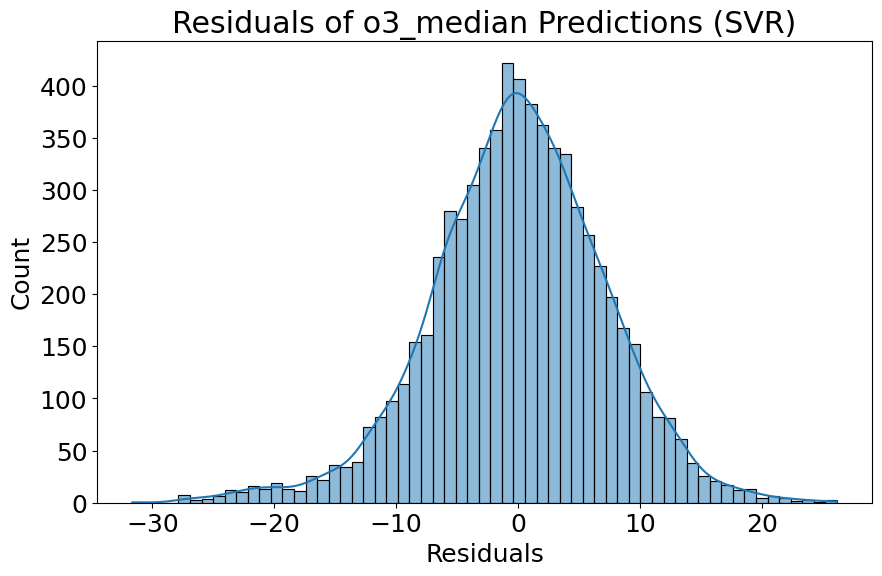


Cross-Validation RMSE scores for o3_median: [7.25934336 7.06300108 7.1072001  7.14175803 7.0787376 ]
Mean Cross-Validation RMSE score for o3_median: 7.1300080357222155
Cross-Validation MAPE scores for o3_median: [4.35036227 3.80830177 4.44532    3.87474476 3.83925184]
Mean Cross-Validation MAPE score for o3_median: 4.063596128854684

 no2_median SVR Root Mean Squared Error:  3.439392076749641
no2_median SVR Mean Absolute Percentage Error: 0.5602868534796953


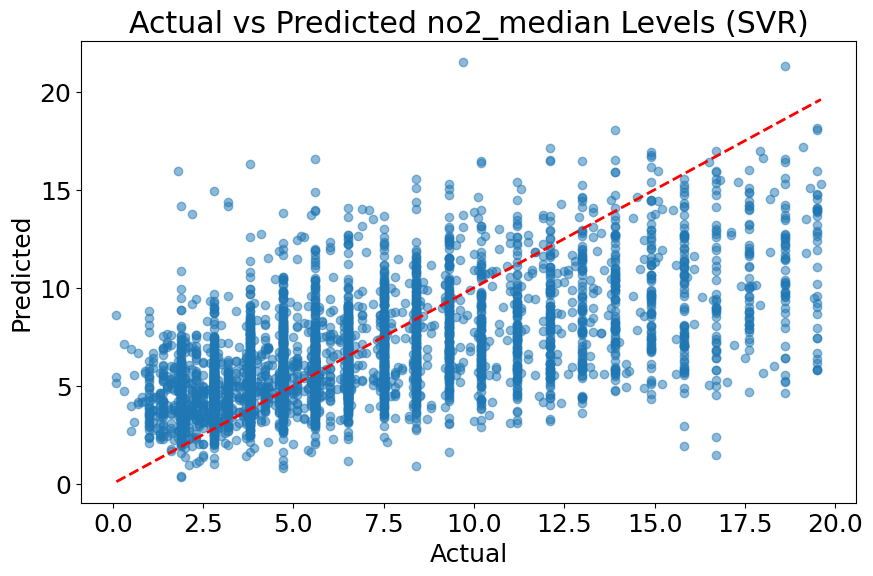

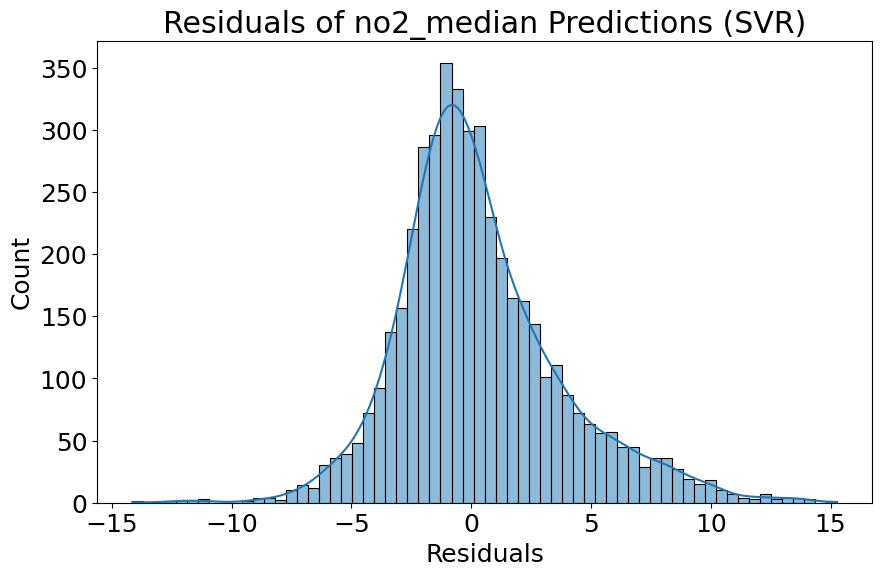


Cross-Validation RMSE scores for no2_median: [3.43123868 3.41116006 3.43539542 3.40858322 3.49035122]
Mean Cross-Validation RMSE score for no2_median: 3.4353457209516263
Cross-Validation MAPE scores for no2_median: [0.58642325 0.5304099  0.5378917  0.52259795 0.51403047]
Mean Cross-Validation MAPE score for no2_median: 0.5382706567756661

 co_median SVR Root Mean Squared Error:  1.0795792011774514
co_median SVR Mean Absolute Percentage Error: 1.0734326166777328


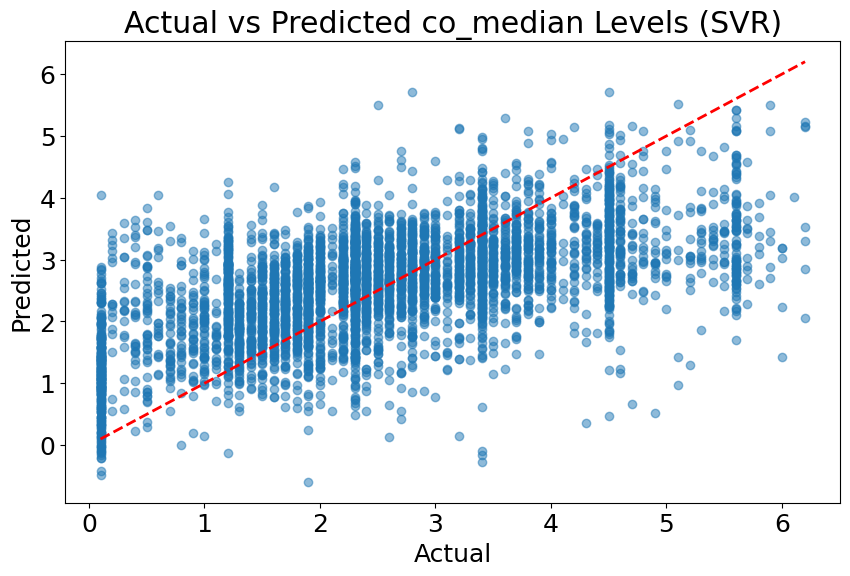

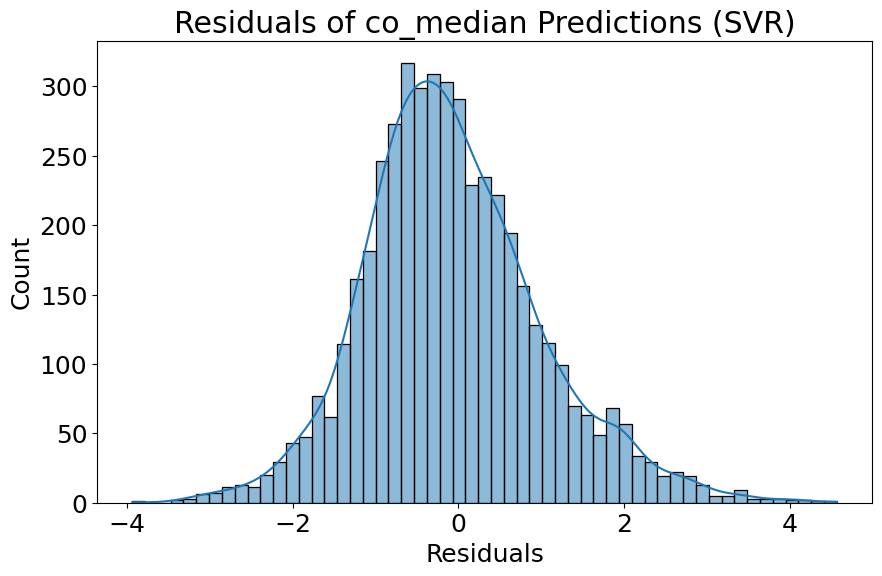


Cross-Validation RMSE scores for co_median: [1.09384316 1.07760331 1.09335663 1.11050745 1.0794855 ]
Mean Cross-Validation RMSE score for co_median: 1.0909592089752134
Cross-Validation MAPE scores for co_median: [1.16299548 1.12351987 1.19988459 1.17735906 1.10642111]
Mean Cross-Validation MAPE score for co_median: 1.1540360208576923


In [ ]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import seaborn as sns


pollutants = ['pm25_median', 'pm10_median', 'o3_median', 'no2_median', 'co_median']
features = ['humidity_median', 'wind-gust_median', 'wind-speed_median', 'temperature_median', 'dew_median', 'pp_feat', 'total_population']
plt.rcParams.update({'font.size': 18})

# Function to calculate root mean squared error
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

for target in pollutants:
    #cleaning data
    clean_data = clean_features(data_copy, features, target)

    X_pre = clean_data[features]
    y_pre = clean_data[target]

    #NaN handling
    X_pre = X_pre.fillna(X_pre.mean())

    scaler = StandardScaler()
    X_pre_scaled = scaler.fit_transform(X_pre)

    poly = PolynomialFeatures(degree=2, include_bias=False)
    X_pre_poly = poly.fit_transform(X_pre_scaled)

    #Train test split
    X_train, X_test, y_train, y_test = train_test_split(X_pre_poly, y_pre, test_size=0.2, random_state=42)

    # Manually setting SVR parameters
    svr_params = {
        'kernel': 'rbf',
        'C': 50,
        'epsilon': 1,
        'gamma': 'auto'
    }

   # Initialize and train the SVR model
    svr_model = SVR(**svr_params)
    svr_model.fit(X_train, y_train)

    # Predictions and evaluation
    svr_pred = svr_model.predict(X_test)
    svr_mse = mean_squared_error(y_test, svr_pred)
    svr_mape = mean_absolute_percentage_error(y_test, svr_pred)
    print(f"\n {target} SVR Root Mean Squared Error: ", np.sqrt(svr_mse))
    print(f"{target} SVR Mean Absolute Percentage Error:", svr_mape)


    #Plot figure for SVR

    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, svr_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'Actual vs Predicted {target} Levels (SVR)')
    plt.savefig(f"Actual_vs_Predicted_{target}_Levels_SVR.png")
    plt.show()

    #Plot figure for residuals for SVR
    svr_residuals = y_test - svr_pred
    plt.figure(figsize=(10, 6))
    sns.histplot(svr_residuals, kde=True)
    plt.xlabel('Residuals')
    plt.ylabel('Count')
    plt.title(f'Residuals of {target} Predictions (SVR)')
    plt.savefig(f"Residuals_of_{target}_Predictions_SVR.png")
    plt.show()

    # Cross-validation for RMSE
    cv_rmse_scores = cross_val_score(svr_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    cv_rmse_scores = np.sqrt(-cv_rmse_scores)
    print(f"\nCross-Validation RMSE scores for {target}: {cv_rmse_scores}")
    print(f"Mean Cross-Validation RMSE score for {target}: {cv_rmse_scores.mean()}")

    # Cross-validation for MAPE
    cv_mape_scores = cross_val_score(svr_model, X_train, y_train, cv=5, scoring='neg_mean_absolute_percentage_error')
    cv_mape_scores = -cv_mape_scores
    print(f"Cross-Validation MAPE scores for {target}: {cv_mape_scores}")
    print(f"Mean Cross-Validation MAPE score for {target}: {cv_mape_scores.mean()}")


# Deep Learning model (Dense)

In [ ]:
"""
Following part regards Deep Learning. It was impossible for us to use it in our shared environement, because of
its hardware limitations. To achieve our results, we've been running it locally. Here is a preview code. To predict 
target variable, change target_column to the name of the column you want to predict. Note: Change pollution_collumns
to the names of the columns you want to omit while training.
"""



plt.rcParams.update({'font.size': 18})
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

data = pd.read_csv("pollution_data.csv")
df = data.copy()
df["Population Staying at Home"] = df["Population Staying at Home"].str.replace(",", "").astype(int)
df["Population Not Staying at Home"] = df["Population Not Staying at Home"].str.replace(",", "").astype(int)

# Create the total_population column
df["total_population"] = df["Population Staying at Home"] + df["Population Not Staying at Home"]

numeric_features = df.select_dtypes(include=['int64', 'float64']).columns


df['Date'] = pd.to_datetime(df['Date'])
df['Month'] = df['Date'].dt.month
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['Year'] = df['Date'].dt.year

#print(df.columns)
"""
df.drop(['latitude', 'longitude', 'humidity_min', 'humidity_max', 'humidity_variance', 'pressure_min',
         'pressure_max', 'pressure_variance', 'pressure_count', 'pressure_variance', 'humidity_count', 'temperature_min', 'temperature_max',
         'temperature_count', 'dew_min', 'dew_max', 'dew_count', 'wind-speed_min', 'wind-speed_max', 'wind-speed_count',
         'wind-gust_min', 'wind-gust_max', 'wind-gust_count', 'pp_feat', 'total_population', 'wind-speed_variance'], axis=1, inplace=True)
"""
# Dropping non-feature variables. TODO: incorporate into prepare_data if time allows // Blazej
#df.drop(['latitude', 'longitude', 'pp_feat', 'total_population'], axis=1, inplace=True)
def prepare_data(df, target_column, pollution_columns):
    """
    Prepares the data for model training

    Parameters:
    - df: Our data.
    - target_column: The name of the target variable column.
    - pollution_columns: A list of names of all pollution-related columns or other stuff we don't want to train on.

    Returns:
    - X: A DataFrame of features, no pollution-related columns, no missing values.
    - y: Target variable series, no missing values.
    """
    df = df.copy()
    # Drop rows where the target variable is missing
    #df.sort_values(by=['County', 'Date'])
    df = df.dropna(subset=[target_column])
    # Debug stuff
    #print('null values count:')
    #print(df.isnull().sum())

    # Handle outliers
    numerical_columns = df.select_dtypes(include=[np.number]).columns.tolist()

    for col in numerical_columns:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 2.0 * IQR
            if col == target_column:
                df = df[df[target_column] <= upper_bound]
            else:
                df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])
                #df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])

    y = df[target_column]
    X = df.drop(['Date', 'City', 'County', 'State'] + pollution_columns, axis=1)
    # Fill NaN values with the mean of each column
    # Quick hack, might fix later.
    for col in X.columns:
        X[col] = X[col].fillna(X[col].mean())
    return X, y

#pollution_columns = ['pm25_min', 'pm25_max', 'pm25_variance', 'pm25_count', 'pm25_median']
#pollution_columns = ['no2_min', 'no2_max', 'no2_variance', 'no2_count', 'no2_median']
#pollution_columns = ['pm10_min', 'pm10_max', 'pm10_variance', 'pm10_count', 'pm10_median']

pollution_columns = ['o3_min', 'o3_max', 'o3_median', 'o3_variance', 'o3_count',
                     'pm25_min', 'pm25_max', 'pm25_median', 'pm25_variance', 'pm25_count',
                     'no2_min', 'no2_max', 'no2_median', 'no2_variance', 'no2_count', 'co_min',
                     'co_max', 'co_median', 'co_variance', 'co_count', 'so2_min', 'so2_max',
                     'so2_median', 'so2_variance', 'so2_count', 'pm10_min', 'pm10_max',
                     'pm10_median', 'pm10_variance', 'pm10_count',
                     ]



target_column = 'pm25_median'

X, y = prepare_data(df, target_column, pollution_columns)
print(f"Xshape: {X.shape}")
# More debug stuff
"""
print('Data prepared - #rows in X')
print(len(X))
print('Data prepared - #rows in Y')
print(len(y))
print("Data prepared - X columns here")
print(X.columns)
print("Data prepared - y columns here")
print(y.name)
"""

from sklearn.model_selection import train_test_split

#X = df.drop(['Date', 'City', 'County', 'State'], axis=1)
#y = df['pm25_median']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)


""" NEW SCALER """
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
# Initialize the scaler
scaler = RobustScaler()
#scaler = MinMaxScaler(feature_range=(0, 1))
# Fit the scaler on the training data
scaler.fit(X_train)

# Transform the training and test data
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


def automatic_feature_selection(X_train, X_test):
    """
    Automatically selects most influential features using RFE
    Parameters:
        X_train - scaled X training set
        X_test - scaled X test set
    returns:
        X_train, test with n features(RFE Parameters)

    """
    # Feature Selection
    selector = RFE(RandomForestClassifier(n_estimators=50, random_state=42), n_features_to_select=32, step=1, verbose=2)
    selector = selector.fit(X_train, y_train)

    # Select the important features based on RFE
    X_train_selected= selector.transform(X_train)
    X_test_selected = selector.transform(X_test)
    return X_train_selected, X_test_selected

#print('check nan in train data')
#print(np.isnan(X_train_seq).any())

def plot_training_validation_loss(history_dict, cumulative_history=None):
    """Plot training and validation loss, optionally accumulation history."""
    plt.figure(figsize=(10, 6))
    train_loss = history_dict['loss'] if cumulative_history is None else cumulative_history['loss'] + history_dict['loss']
    val_loss = history_dict['val_loss'] if cumulative_history is None else cumulative_history['val_loss'] + history_dict['val_loss']
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title(f'Model loss: {target_column.title()}')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()
    if cumulative_history is None:
        cumulative_history = {'loss': history_dict['loss'], 'val_loss': history_dict['val_loss']}
    else:
        cumulative_history['loss'].extend(history_dict['loss'])
        cumulative_history['val_loss'].extend(history_dict['val_loss'])
    return cumulative_history
def plot_actual_vs_predicted(y_test, predictions):
    """Plot actual versus predicted values."""
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, predictions.flatten(), alpha=0.6)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Actual vs Predicted Values, target: {target_column.title()}')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)  # Diagonal line
    plt.show()

def plot_residuals(predictions, y_test):
    """Plot residuals of predictions."""
    residuals = y_test - predictions.flatten()
    plt.figure(figsize=(10, 6))
    plt.scatter(predictions.flatten(), residuals, alpha=0.6)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title(f'Residuals of Predictions, target: {target_column.title()}')
    plt.show()

"""Model here"""

import tensorflow as tf
from tensorflow.keras.models import Sequential          # This shows error for in my local files, still works though (????)
from tensorflow.keras.layers import LSTM, Dense, Input, BatchNormalization  # Input might not be needed but silences some warnings
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Dense(16, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    #BatchNormalization(),
    Dropout(0.2),

    Dense(256, activation='sigmoid', ),  # Increase and regularize
    #BatchNormalization(),
    Dropout(0.2 ),

    Dense(128, activation='selu', ),  # Increase and regularize
    #BatchNormalization(),
    #Dropout(0.3),

    Dense(32, activation='selu', ),

    Dense(16, activation='relu', ),  # Increase and regularize
    #BatchNormalization(),
    #Dropout(0.1),

    Dense(8, activation='elu', ),  # Increase and regularize
    #BatchNormalization(),


    Dense(1, activation='linear')  # Output layer for regression
])
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse')
# Early Stopping Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True) #FOR NON INTERACTIVE TRAINING
total_epochs = 500
epochs_per_batch = 100
cumulative_history = {'loss': [], 'val_loss': []}
verbose = 1                    # change before training
afs = 0                        # automatic feature selection (on/off)


# Modified training loop
if afs == 1:
    X_train_scaled, X_test_scaled = automatic_feature_selection(X_train_scaled, X_test_scaled)

for i in range(total_epochs // epochs_per_batch):
    print(f"Batch {i+1}/{int(total_epochs / epochs_per_batch)}")
    batch_history = model.fit(X_train_scaled, y_train, epochs=epochs_per_batch, validation_split=0.2)
    predictions = model.predict(X_test_scaled)
    cumulative_history = plot_training_validation_loss(batch_history.history, cumulative_history)

    if verbose == 1:
        test_loss = model.evaluate(X_test_scaled, y_test)
        print(f"Test Loss: {test_loss}, batches run: {i+1}")
        plot_actual_vs_predicted(y_test, predictions)
        plot_residuals(predictions, y_test)
    decision = input("Continue training? (y/n): ")
    if decision.lower() != 'y':
        break

#plot_training_validation_loss(cumulative_history)


#history = model.fit(X_train_scaled, y_train, epochs=300, validation_split=0.2, callbacks=[early_stopping])
predictions = model.predict(X_test_scaled)
test_loss=model.evaluate(X_test_scaled, y_test)
print(f"Test Loss: {test_loss}")

#print(f"Predictions length: {len(predictions)}")
#print(f'Test Y length: {len(y_test)} ')



model.save_weights('no2new.weights.h5')

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=2dc78d70-4849-47c1-ba7c-824196c0e789' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>